In [230]:
# Imports
import os
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import joblib
import pickle

import torch

from darts import TimeSeries
from darts.models import  RandomForest, LinearRegressionModel,  \
                        LightGBMModel, CatBoostModel, XGBModel,  \
                        BlockRNNModel, NBEATSModel, NHiTSModel, \
                        TCNModel, TFTModel


from sklearn.svm import SVR
from sklearn.linear_model import PoissonRegressor

from darts.dataprocessing.transformers import Scaler
from darts.utils.likelihood_models import GaussianLikelihood

import warnings
warnings.filterwarnings('ignore')

# Configuration

In [231]:
prj_path = '../'
data_path = prj_path + "data/new_data/DH/squeezed/"
prj_path_opt= prj_path + "optimize_hyperparam/opt_results/"
output_process = prj_path + "data/new_data/DH/processed_data/"
output_featureselection = prj_path + "data/new_data/DH/feature_selection/"

In [232]:
all_cities = [
        'An Giang', 'BR Vũng Tàu', 'Bình Phước', 'Bình Thuận', 'Bình Định',
        'Bạc Liêu', 'Bắc Kạn', 'Bắc Giang', 'Cao Bằng', 'Cà Mau',
        'Cần Thơ', 'Gia Lai', 'Hà Giang', 'Hà Nội', 'Hà Tĩnh',
        'Hòa Bình','Hưng Yên', 'Hải Dương', 'Hải Phòng', 'Khánh Hòa', 'Kiên Giang',
        'Kon Tum', 'Lai Châu', 'Long An', 'Lào Cai', 'Lâm Đồng',
        'Lạng Sơn','Nam Định', 'Nghệ An', 'Ninh Bình', 'Ninh Thuận',
        'Phú Thọ', 'Phú Yên', 'Quảng Bình', 'Quảng Nam', 'Quảng Ngãi',
        'Quảng Ninh', 'Quảng Trị', 'Sóc Trăng', 'Sơn La', 'TT Huế',
        'Thanh Hóa', 'Thái Bình', 'Thái Nguyên', 'Tiền Giang', 'Trà Vinh',
        'Tuyên Quang', 'Tây Ninh', 'Vĩnh Phúc', 'Yên Bái', 'Điện Biên',
        'Đà Nẵng', 'Đắk Nông', 'Đắk Lắk', 'Đồng Tháp'
]
# cities = ['Hà Nội','Hải Phòng','Quảng Ninh','Nam Định','Thái Bình','Quảng Nam','Quảng Ngãi', 'Phú Yên',
#           'Ninh Thuận', 'Bình Thuận', 'Tây Ninh', 'Bình Phước', 'An Giang', 'Tiền Giang','Cần Thơ', 'Trà Vinh']

cities = [ 'Bình Phước', 'An Giang','Quảng Ninh']

In [233]:
# Set hyperparameters as args using the Configuration class
class Configuration():
    def __init__(self):
        # lấy bộ test dài 36 tháng = 3 năm
        self.test_size = 36
        # là nhìn vào dữ liệu trước 3 tháng và dự phóng        
        self.look_back = 3
        # dự phóng n-step trong 6 tháng
        self.n_predicted_period_months = 6
        self.n_features = 3
        self.seed = 42
        # mỗi phần tử x trong tập suppervise có độ lớn là 16 = 16 tháng
        self.batch_size = 16
        self.device = torch.device("cuda")
        self.epochs = 300
        #others
        self.labels = "Dengue_fever_rates"
        # Input param for Optimize Run
        self.ntry = 1
        self.njob = 1

args = Configuration()

# Seeding

In [234]:
def seed_everything(seed: int):
    import random
    import numpy as np
    import torch
    
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

seed_everything(args.seed)

# Supporting functions

In [235]:
import requests

def send_to_telegram(message):

    apiToken = '5908735099:AAGVSLrW62aXPBP-GrMvxoVgMsuJxXJpP1Q'
    chatID = '@ptn_announcement'
    apiURL = f'https://api.telegram.org/bot{apiToken}/sendMessage'

    try:
        response = requests.post(apiURL, json={'chat_id': chatID, 'text': message})
        print(response.text)
    except Exception as e:
        message_error = "Bị lỗi rùi: "+str(e)
        response = requests.post(apiURL, json={'chat_id': chatID, 'text': message_error})
        print(e)

In [236]:
def get_dict_all_city_data():
  cities_data = {}  
  for city in cities:
    city_result = pd.read_excel(prj_path+'data/new_data/DH/squeezed/squeezed_'+city+'.xlsx')  
    """Get all data from all city in 1997 - 2016""" 
    city_result = city_result.loc[city_result['year_month'] < '2017-1-1'] 
    cities_data[city] = city_result
  return cities_data

In [237]:
# Define data (pre-)processing functions
# modification
def get_city_data(city_name, dict_full_data):
    """Returns Diarrhoea rate and climate data""" 
    city_data = dict_full_data[city_name].drop(columns=['Diarrhoea_cases','Diarrhoea_rates', 'province',
                                                        'Influenza_rates','Influenza_cases',
                                                        'Dengue_fever_cases', 'year', 'month'], 
                                                                  axis=1, 
                                                                  inplace=False)    
    return city_data

def convert_to_stationary(city_data):
    """Subtracts previous value for all cols except disease rates"""
    for col_name in city_data.columns:
        if col_name != 'Diarrhoea_rates':
            try:
                city_data[col_name] = city_data[col_name] - city_data[col_name].shift()
            except:
                print(col_name)
    return city_data

def impute_missing_value(city_data):
    """
    Imputes 0 for first 12 months, 
    last year's value for months 12-24, 
    and minimum value of last two years for months 25+
    """
    for col in city_data.columns:
        for index in range(len(city_data[col])):
            if np.isnan(city_data[col].iloc[index]):
                if index < 12:
                    city_data[col].iloc[index] = 0
                elif index >= 12 and index <= 24:
                    city_data[col].iloc[index] = city_data[col].iloc[index - 12]
                else:
                    city_data[col].iloc[index] = min(city_data[col].iloc[index - 12], city_data[col].iloc[index - 24])
    return city_data

In [238]:
def clean_full_data(dict_full_data):
    climate_and_disease_feats = ['Total_Evaporation',
       'Total_Rainfall', 'Max_Daily_Rainfall', 'n_raining_days',
       'Average_temperature', 'Max_Average_Temperature',
       'Min_Average_Temperature', 'Max_Absolute_Temperature',
       'Min_Absolute_Temperature', 'Average_Humidity', 'Min_Humidity',
       'n_hours_sunshine', 'Dengue_fever_rates']
    for city in cities:
        city_data = get_city_data(city_name=city,dict_full_data = dict_full_data)
        city_data_features = city_data[climate_and_disease_feats]
        city_data_features = impute_missing_value(city_data_features)
        city_data_features = convert_to_stationary(city_data_features)
        city_data_features.dropna(inplace=True)
        city_data_features.loc[:, "year_month"] = city_data["year_month"]
        dict_full_data[city] = city_data_features
    return dict_full_data


In [239]:
def to_supervised(data,  d_out, d_in, features_list=[]):
    """
    Frames time-series as supervised learning dataset.
    
    Args:
      d_in: lookback window
      d_out: number of predicted months
      features_list: list of all features **where last col is the disease incidence**

    Returns:
      Numpy arrays of disease incidence (y) and other predictors (X)
    """
    X, y = list(), list()
    for index, _ in enumerate(data):
        in_end = index + d_in
        out_end = in_end + d_out
        if out_end <= len(data):
            if len(features_list) == 0 :
                X.append(data[index: in_end, :-1])
            else:
                X.append(data[index: in_end, features_list])
            y.append(data[out_end-1: out_end, -1])
    return np.array(X), np.array(y).reshape(len(y))

In [240]:
def train_and_evaluate(df_train, df_eval, model, feature_list , labels, scaler, is_dl_algo,is_sklearn_model,nstep):
  """
  $df: pandas.DataFrame object containing data for training and testing model:
  $model: darts model object
  $feature_list: Names of the features used as model input
  $label: the value the model will be trained to predict
  $scaler: scaler object. Note: the scaler will be fitted on training data and applied to test data
  $lags: how much to look back into the past to output prediction
  $split_index: the point at which to divide train and test_data

  """

  if is_dl_algo == 1:
    print("🍋")
  else:
      if is_sklearn_model == 1:
        print("🐝Vãi òoo")
        train = df_train[feature_list+[args.labels]].iloc[:,:].to_numpy()
        df_eval = df_eval[-args.test_size - args.look_back-(nstep - 1): ] #Fit size of the test by step
        test = df_eval[feature_list+[args.labels]].iloc[:,:].to_numpy()
        x_train,y_train = to_supervised(train, d_out=nstep, d_in=args.look_back )
        x_train = x_train.reshape(len(x_train),x_train.shape[1]*x_train.shape[2])
        x_test,y_test = to_supervised(test, d_out=nstep, d_in=args.look_back )
        x_test = x_test.reshape(len(x_test),x_test.shape[1]*x_test.shape[2])

        model = model.fit(x_train,y_train)
        prediction = model.predict(x_test)
        
        print("🐹Len(prediction):",len(prediction))
        df_eval = df_eval[-args.test_size:]
        y_true = df_eval[labels].values

        df_eval_pred_inverse = df_eval[-args.test_size:]
        df_eval_pred_inverse[labels]= prediction
        y_pred = scaler.inverse_transform(df_eval_pred_inverse.iloc[:,:-1])[:,[-1]].reshape(len(prediction))  
      else:
        print("🐝Oát zúppppp")
        x_train = TimeSeries.from_dataframe(df_train, "year_month", feature_list)
        y_train = TimeSeries.from_dataframe(df_train, "year_month", labels)

        df_eval = df_eval[-args.test_size - args.look_back-(nstep - 1): ]

        x_test = TimeSeries.from_dataframe(df_eval, "year_month", feature_list)
        y_test = TimeSeries.from_dataframe(df_eval, "year_month", labels)

        print("🐝Nà ní đa phắc")
        model.fit(y_train, past_covariates = x_train)
        print("🐝Still fine")
        prediction = model.predict(args.test_size, past_covariates = x_test, num_samples=1)
        print("🐝Nee")
        df_eval = df_eval[-args.test_size:]
        y_true = df_eval[labels].values
        df_eval[labels]= np.array(prediction._xa).squeeze()
        y_pred = scaler.inverse_transform(df_eval.iloc[:,:-1])[:,[-1]].reshape(len(prediction))


  mse = mean_squared_error(y_true, y_pred)
  mae = mean_absolute_error(y_true, y_pred)
  rmse = mse**0.5
  mape = mean_absolute_percentage_error(y_true, y_pred)
  print(f"mean_squared_error: {mse:.4f}")
  print(f"rmse: {rmse}")
  print(f"mape: {mape}")
  return model, y_true, y_pred, mse, mae, rmse, mape

In [241]:
def output_prediction_for_location(df_train, df_eval, model, location, feature_list, 
                                                labels, scaler, is_dl_algo, is_sklearn_model ,nstep):
    """train and generate prediction for a province
    df: DataFrame object containing features and label(s) for training model
    localtion: location_name
    feature_list: list of features used as model input,  must be among the column names of df
    labels: the values model will be trained to predict
    scaler: sklearn scaler object
    lags: how long into the past to look back when making prediction
    split_index: the point at which to divide data into the train and test subsets.
    """
    model, y_true, prediction_inverse, mse, mae, rmse, mape = train_and_evaluate(df_train, df_eval, model, feature_list, labels, scaler,is_dl_algo, is_sklearn_model,nstep)
    df_prediction = pd.DataFrame({"Date": df_eval["year_month"][-len(prediction_inverse):],
                                  "Observed": y_true[-len(prediction_inverse):],
                                  f"{nstep}-month": prediction_inverse})
    

    df_prediction["City"] = location
    df_prediction[f"RMSE_{nstep}-month"] = rmse
    df_prediction[f"MAE_{nstep}-month"] = mae
    df_prediction[f"MAPE_{nstep}-month"] = mape
    df_prediction[f"MSE_{nstep}-month"] = mse

    df_compare_test_predict = pd.DataFrame({'y_true':y_true, 'y_pred':prediction_inverse})
    df_compare_test_predict.plot()
    plt.legend()
    plt.title(f"{nstep}step_{type(model).__name__}_DF_{location}")
    plt.savefig(f"./predict_results/{nstep}step_{type(model).__name__}_DF_{location}_tkde.png", dpi=300)
    plt.show()

    temp_rs = f"{rmse},{mae},{mape},{mse}"
    print("rmse,mae,mape,mse")
    print(temp_rs)
    
    return df_prediction, model

In [242]:
def getDataWithSelectedFeature(city, next_predicted_month):
  selected_feature = []
  df = pd.read_csv(output_featureselection+str(next_predicted_month)+"step_feature_selection_3_most.csv")
  for row in range(len(df)):
    if (df["City"][row] == city):
      selected_feature.append(df["1st_Feature"][row])
      selected_feature.append(df["2nd_Feature"][row])
      selected_feature.append(df["3rd_Feature"][row])
  return selected_feature

In [243]:
def getHyperParams(model_name, city, nstep):
  folder_path = f'../optimize_hyperparam/opt_results/opt_res_ml_26102023/{model_name}/'
  file_path = folder_path+ f'261023_DF_opt_hyperparam_{model_name}_{nstep}-nstep.xlsx'
  df_optimized = pd.read_excel(file_path)
  display(df_optimized)
  df_optimized_params = df_optimized.loc[(df_optimized['City'] == city)]
  return df_optimized_params

# Training

✨✨✨✨✨✨✨✨1✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨RandomForest✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨Bình Phước✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,n_estimators,max_depth,random_state
0,Bình Phước,RandomForest,21.371176,1,3,"-1,-2,-3",1,51,3,10
1,An Giang,RandomForest,15.261093,1,3,"-1,-2,-3",1,158,5,3
2,Quảng Ninh,RandomForest,5.156378,1,3,"-1,-2,-3",1,153,1,31


🐝Oát zúppppp
🐝Nà ní đa phắc
🐝Still fine
🐝Nee
mean_squared_error: 388.0410
rmse: 19.69875602751323
mape: 4.045677070261802


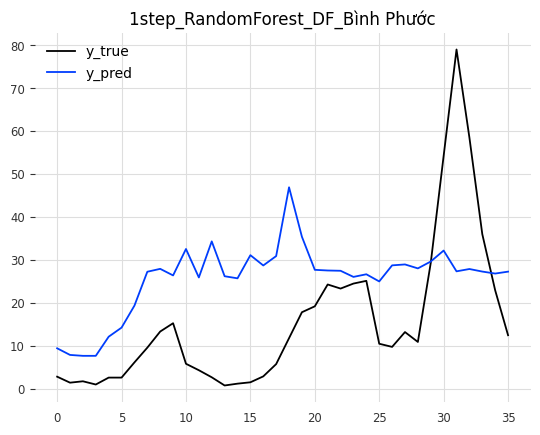

rmse,mae,mape,mse
19.69875602751323,16.215520113139874,4.045677070261802,388.04098903148883
✨✨✨✨✨✨✨✨An Giang✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,n_estimators,max_depth,random_state
0,Bình Phước,RandomForest,21.371176,1,3,"-1,-2,-3",1,51,3,10
1,An Giang,RandomForest,15.261093,1,3,"-1,-2,-3",1,158,5,3
2,Quảng Ninh,RandomForest,5.156378,1,3,"-1,-2,-3",1,153,1,31


🐝Oát zúppppp
🐝Nà ní đa phắc
🐝Still fine
🐝Nee
mean_squared_error: 490.8893
rmse: 22.156021761846183
mape: 3.0863259198090294


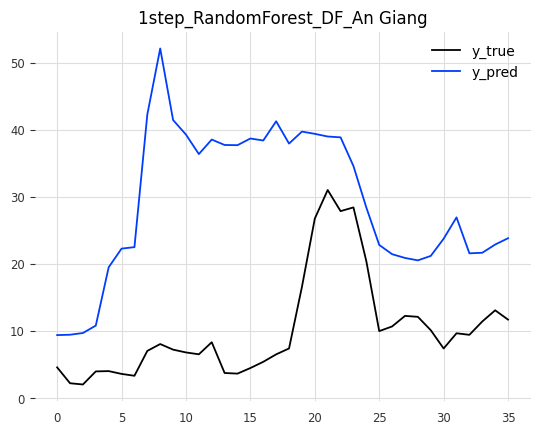

rmse,mae,mape,mse
22.156021761846183,19.03870049105666,3.0863259198090294,490.8893003114017
✨✨✨✨✨✨✨✨Quảng Ninh✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,n_estimators,max_depth,random_state
0,Bình Phước,RandomForest,21.371176,1,3,"-1,-2,-3",1,51,3,10
1,An Giang,RandomForest,15.261093,1,3,"-1,-2,-3",1,158,5,3
2,Quảng Ninh,RandomForest,5.156378,1,3,"-1,-2,-3",1,153,1,31


🐝Oát zúppppp
🐝Nà ní đa phắc
🐝Still fine
🐝Nee
mean_squared_error: 7.6320
rmse: 2.7626119733673713
mape: 1198307358486741.0


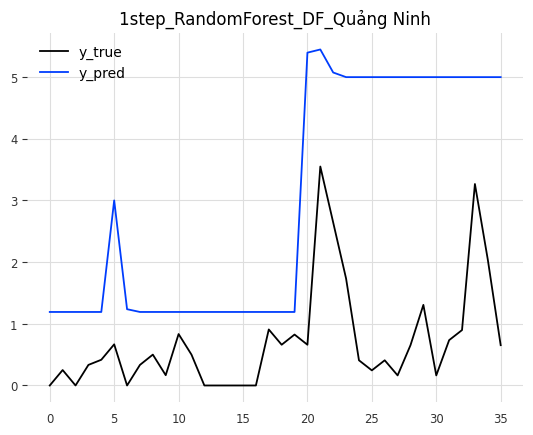

rmse,mae,mape,mse
2.7626119733673713,2.240692354019407,1198307358486741.0,7.632024915392762
✨✨✨✨✨✨✨✨LinearRegressionModel✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨Bình Phước✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,random_state
0,Bình Phước,LinearRegressionModel,15.454550,1,3,"-1,-2,-3",1,24
1,An Giang,LinearRegressionModel,9.793240,1,3,"-1,-2,-3",1,33
2,Quảng Ninh,LinearRegressionModel,2.156104,1,3,"-1,-2,-3",1,20


🐝Oát zúppppp
🐝Nà ní đa phắc
🐝Still fine
🐝Nee
mean_squared_error: 344.6558
rmse: 18.56490673652867
mape: 2.7082571251441263


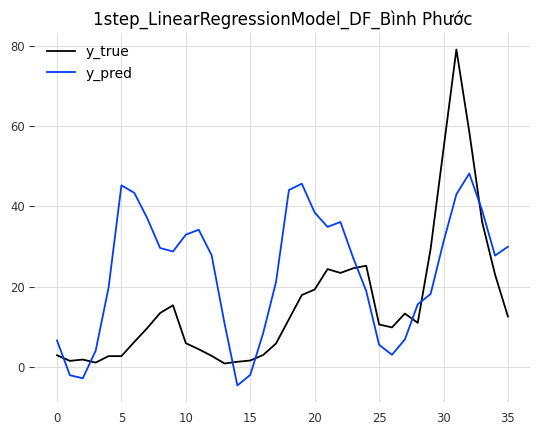

rmse,mae,mape,mse
18.56490673652867,14.732897170343952,2.7082571251441263,344.6557621360075
✨✨✨✨✨✨✨✨An Giang✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,random_state
0,Bình Phước,LinearRegressionModel,15.454550,1,3,"-1,-2,-3",1,24
1,An Giang,LinearRegressionModel,9.793240,1,3,"-1,-2,-3",1,33
2,Quảng Ninh,LinearRegressionModel,2.156104,1,3,"-1,-2,-3",1,20


🐝Oát zúppppp
🐝Nà ní đa phắc
🐝Still fine
🐝Nee
mean_squared_error: 184.7688
rmse: 13.592970349615078
mape: 1.864611516690918


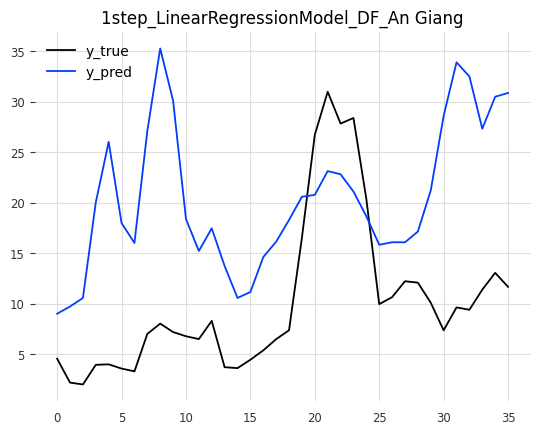

rmse,mae,mape,mse
13.592970349615078,11.768939375892574,1.864611516690918,184.76884292551466
✨✨✨✨✨✨✨✨Quảng Ninh✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,random_state
0,Bình Phước,LinearRegressionModel,15.454550,1,3,"-1,-2,-3",1,24
1,An Giang,LinearRegressionModel,9.793240,1,3,"-1,-2,-3",1,33
2,Quảng Ninh,LinearRegressionModel,2.156104,1,3,"-1,-2,-3",1,20


🐝Oát zúppppp
🐝Nà ní đa phắc
🐝Still fine
🐝Nee
mean_squared_error: 4.4792
rmse: 2.116421256551339
mape: 1874874035755876.0


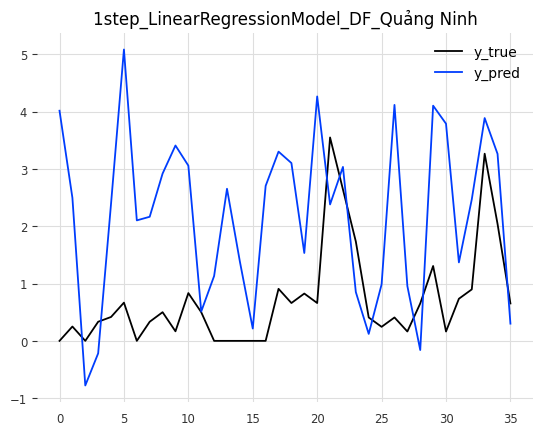

rmse,mae,mape,mse
2.116421256551339,1.7409935087793236,1874874035755876.0,4.479238935182349
✨✨✨✨✨✨✨✨CatBoostModel✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨Bình Phước✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,learning_rate,n_estimators,max_depth,random_state,likelihood,quantiles,bagging_temperature,border_count,l2_leaf_reg,random_strength
0,Bình Phước,CatBoost,19.413033,1,3,"-1,-2,-3",1,0.033244,179,2,467,quantile,IsNone,28.760768,71,1.557732,0.576093
1,An Giang,CatBoost,14.767108,1,3,"-1,-2,-3",1,0.083015,186,8,38,quantile,"0.1,0.5,0.9",32.306882,135,3.842357,5.308857
2,Quảng Ninh,CatBoost,4.984099,1,3,"-1,-2,-3",1,0.072723,122,6,46,quantile,"0.1,0.5,0.9",42.141802,237,3.608348,9.486773


🐝Oát zúppppp
🐝Nà ní đa phắc
🐝Still fine
🐝Nee
mean_squared_error: 270.6179
rmse: 16.45046943790771
mape: 2.663455702525134


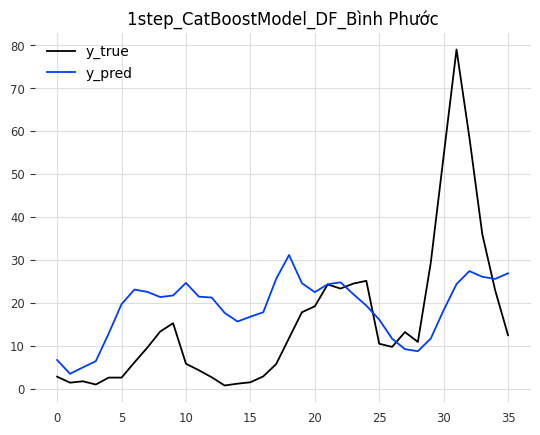

rmse,mae,mape,mse
16.45046943790771,12.257539916998361,2.663455702525134,270.6179447275356
✨✨✨✨✨✨✨✨An Giang✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,learning_rate,n_estimators,max_depth,random_state,likelihood,quantiles,bagging_temperature,border_count,l2_leaf_reg,random_strength
0,Bình Phước,CatBoost,19.413033,1,3,"-1,-2,-3",1,0.033244,179,2,467,quantile,IsNone,28.760768,71,1.557732,0.576093
1,An Giang,CatBoost,14.767108,1,3,"-1,-2,-3",1,0.083015,186,8,38,quantile,"0.1,0.5,0.9",32.306882,135,3.842357,5.308857
2,Quảng Ninh,CatBoost,4.984099,1,3,"-1,-2,-3",1,0.072723,122,6,46,quantile,"0.1,0.5,0.9",42.141802,237,3.608348,9.486773


🐝Oát zúppppp
🐝Nà ní đa phắc
🐝Still fine
🐝Nee
mean_squared_error: 148.1346
rmse: 12.171055658760611
mape: 1.6325436858538607


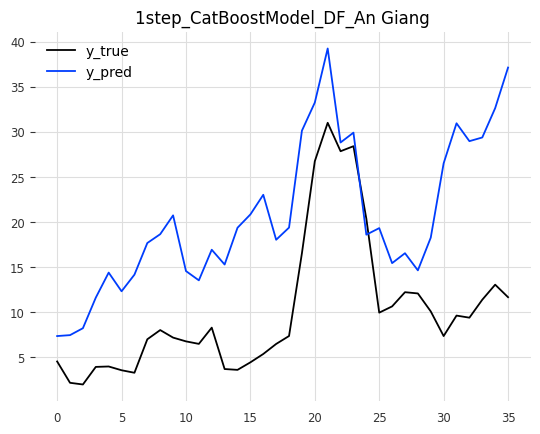

rmse,mae,mape,mse
12.171055658760611,10.557942840121592,1.6325436858538607,148.1345958486487
✨✨✨✨✨✨✨✨Quảng Ninh✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,learning_rate,n_estimators,max_depth,random_state,likelihood,quantiles,bagging_temperature,border_count,l2_leaf_reg,random_strength
0,Bình Phước,CatBoost,19.413033,1,3,"-1,-2,-3",1,0.033244,179,2,467,quantile,IsNone,28.760768,71,1.557732,0.576093
1,An Giang,CatBoost,14.767108,1,3,"-1,-2,-3",1,0.083015,186,8,38,quantile,"0.1,0.5,0.9",32.306882,135,3.842357,5.308857
2,Quảng Ninh,CatBoost,4.984099,1,3,"-1,-2,-3",1,0.072723,122,6,46,quantile,"0.1,0.5,0.9",42.141802,237,3.608348,9.486773


🐝Oát zúppppp
🐝Nà ní đa phắc
🐝Still fine
🐝Nee
mean_squared_error: 24.2190
rmse: 4.921281983187399
mape: 3568032544550133.5


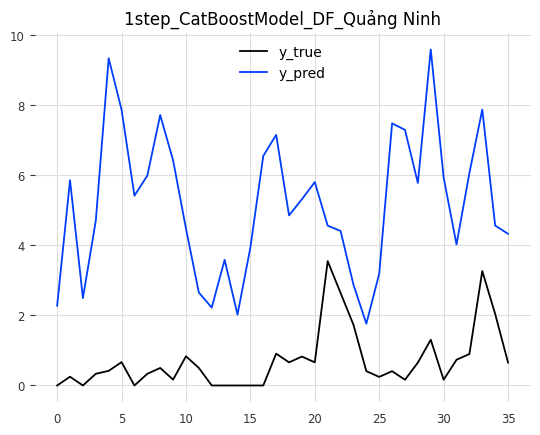

rmse,mae,mape,mse
4.921281983187399,4.459877105399728,3568032544550133.5,24.219016358044897
✨✨✨✨✨✨✨✨XGBModel✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨Bình Phước✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,random_state,likelihood
0,Bình Phước,XGBModel,33.429275,1,3,"-1,-2,-3",1,11,quantile
1,An Giang,XGBModel,35.617705,1,3,"-1,-2,-3",1,5,quantile
2,Quảng Ninh,XGBModel,5.058884,1,3,"-1,-2,-3",1,23,quantile


🐝Oát zúppppp
🐝Nà ní đa phắc
🐝Still fine
🐝Nee
mean_squared_error: 4951.2486
rmse: 70.36510907267701
mape: 8.043089668755885


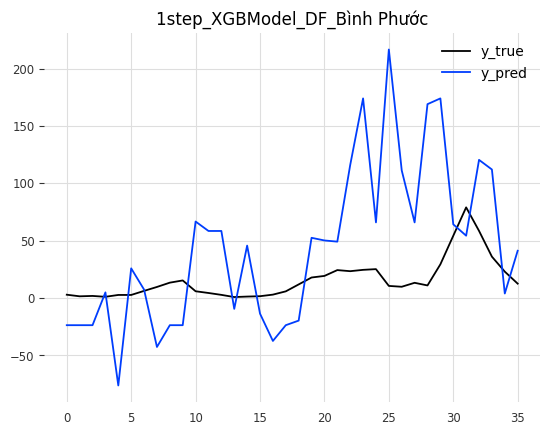

rmse,mae,mape,mse
70.36510907267701,53.08699390404981,8.043089668755885,4951.248574809732
✨✨✨✨✨✨✨✨An Giang✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,random_state,likelihood
0,Bình Phước,XGBModel,33.429275,1,3,"-1,-2,-3",1,11,quantile
1,An Giang,XGBModel,35.617705,1,3,"-1,-2,-3",1,5,quantile
2,Quảng Ninh,XGBModel,5.058884,1,3,"-1,-2,-3",1,23,quantile


🐝Oát zúppppp
🐝Nà ní đa phắc
🐝Still fine
🐝Nee
mean_squared_error: 1052.6362
rmse: 32.44435536364024
mape: 3.831969991196966


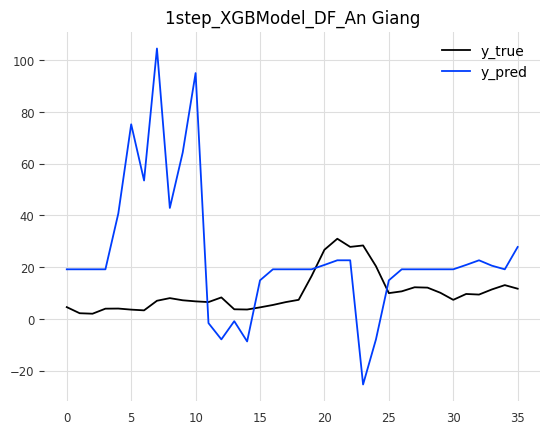

rmse,mae,mape,mse
32.44435536364024,22.199818214297075,3.831969991196966,1052.6361949621712
✨✨✨✨✨✨✨✨Quảng Ninh✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,random_state,likelihood
0,Bình Phước,XGBModel,33.429275,1,3,"-1,-2,-3",1,11,quantile
1,An Giang,XGBModel,35.617705,1,3,"-1,-2,-3",1,5,quantile
2,Quảng Ninh,XGBModel,5.058884,1,3,"-1,-2,-3",1,23,quantile


🐝Oát zúppppp
🐝Nà ní đa phắc
🐝Still fine
🐝Nee
mean_squared_error: 412.4936
rmse: 20.309938136846082
mape: 1.0491335231488936e+16


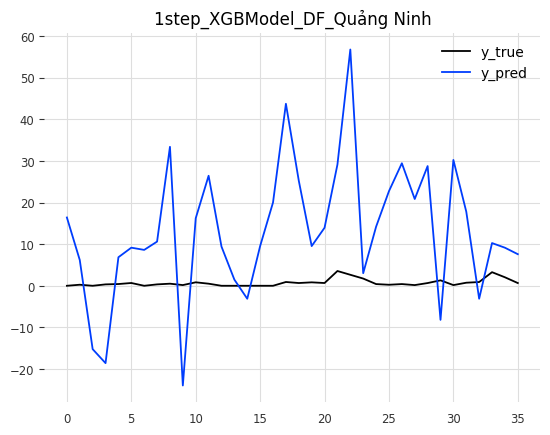

rmse,mae,mape,mse
20.309938136846082,16.63011628390002,1.0491335231488936e+16,412.49358712251484
✨✨✨✨✨✨✨✨2✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨RandomForest✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨Bình Phước✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,n_estimators,max_depth,random_state
0,Bình Phước,RandomForest,18.440673,1,4,"-2,-3,-4",1,111,13,1
1,An Giang,RandomForest,7.087308,1,4,"-2,-3,-4",1,63,5,35
2,Quảng Ninh,RandomForest,10.159877,1,4,"-2,-3,-4",1,56,6,37


🐝Oát zúppppp
🐝Nà ní đa phắc
🐝Still fine
🐝Nee
mean_squared_error: 1335.5035
rmse: 36.544540917489286
mape: 4.7215935432672245


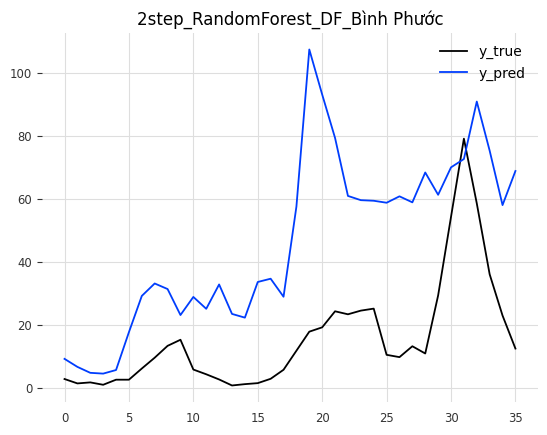

rmse,mae,mape,mse
36.544540917489286,30.622410029015597,4.7215935432672245,1335.503470870049
✨✨✨✨✨✨✨✨An Giang✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,n_estimators,max_depth,random_state
0,Bình Phước,RandomForest,18.440673,1,4,"-2,-3,-4",1,111,13,1
1,An Giang,RandomForest,7.087308,1,4,"-2,-3,-4",1,63,5,35
2,Quảng Ninh,RandomForest,10.159877,1,4,"-2,-3,-4",1,56,6,37


🐝Oát zúppppp
🐝Nà ní đa phắc
🐝Still fine
🐝Nee
mean_squared_error: 89.2343
rmse: 9.446388947377532
mape: 1.271055102717071


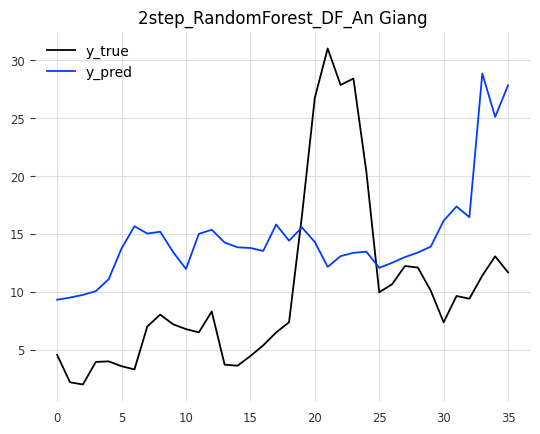

rmse,mae,mape,mse
9.446388947377532,8.341310691811653,1.271055102717071,89.23426414513641
✨✨✨✨✨✨✨✨Quảng Ninh✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,n_estimators,max_depth,random_state
0,Bình Phước,RandomForest,18.440673,1,4,"-2,-3,-4",1,111,13,1
1,An Giang,RandomForest,7.087308,1,4,"-2,-3,-4",1,63,5,35
2,Quảng Ninh,RandomForest,10.159877,1,4,"-2,-3,-4",1,56,6,37


🐝Oát zúppppp
🐝Nà ní đa phắc
🐝Still fine
🐝Nee
mean_squared_error: 81.6771
rmse: 9.037538436378451
mape: 8347223944587890.0


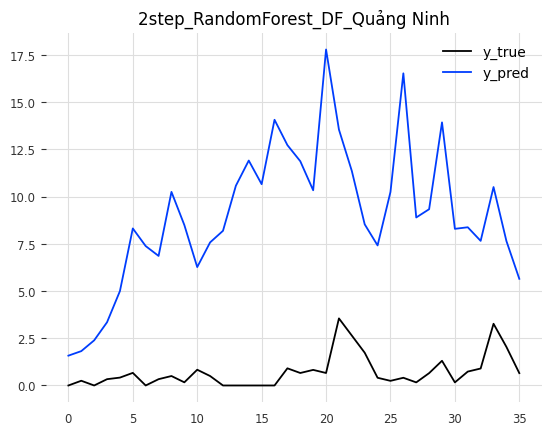

rmse,mae,mape,mse
9.037538436378451,8.312991034642595,8347223944587890.0,81.67710098901787
✨✨✨✨✨✨✨✨LinearRegressionModel✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨Bình Phước✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,random_state
0,Bình Phước,LinearRegressionModel,16.328277,1,4,"-2,-3,-4",1,19
1,An Giang,LinearRegressionModel,10.967351,1,4,"-2,-3,-4",1,42
2,Quảng Ninh,LinearRegressionModel,2.383358,1,4,"-2,-3,-4",1,1


🐝Oát zúppppp
🐝Nà ní đa phắc
🐝Still fine
🐝Nee
mean_squared_error: 321.4726
rmse: 17.929656829387422
mape: 3.0179503894840525


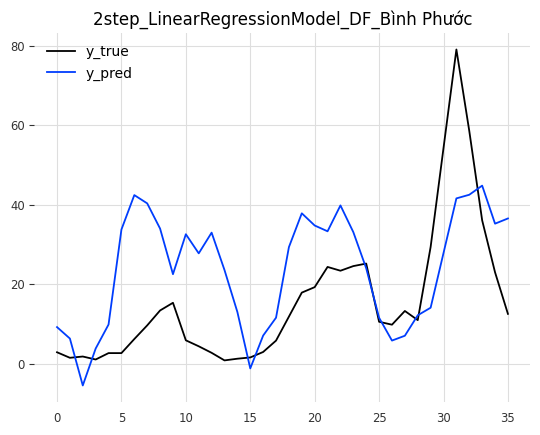

rmse,mae,mape,mse
17.929656829387422,14.50540786339661,3.0179503894840525,321.472594019599
✨✨✨✨✨✨✨✨An Giang✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,random_state
0,Bình Phước,LinearRegressionModel,16.328277,1,4,"-2,-3,-4",1,19
1,An Giang,LinearRegressionModel,10.967351,1,4,"-2,-3,-4",1,42
2,Quảng Ninh,LinearRegressionModel,2.383358,1,4,"-2,-3,-4",1,1


🐝Oát zúppppp
🐝Nà ní đa phắc
🐝Still fine
🐝Nee
mean_squared_error: 195.5684
rmse: 13.984577150904904
mape: 2.0226315379199753


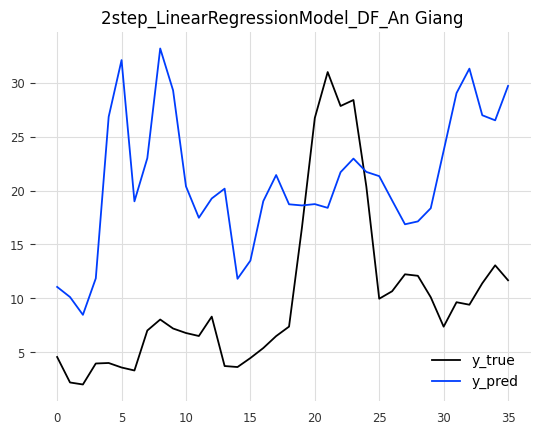

rmse,mae,mape,mse
13.984577150904904,12.402518518473059,2.0226315379199753,195.56839808961155
✨✨✨✨✨✨✨✨Quảng Ninh✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,random_state
0,Bình Phước,LinearRegressionModel,16.328277,1,4,"-2,-3,-4",1,19
1,An Giang,LinearRegressionModel,10.967351,1,4,"-2,-3,-4",1,42
2,Quảng Ninh,LinearRegressionModel,2.383358,1,4,"-2,-3,-4",1,1


🐝Oát zúppppp
🐝Nà ní đa phắc
🐝Still fine
🐝Nee
mean_squared_error: 4.4467
rmse: 2.1087279486751256
mape: 1696288200135148.2


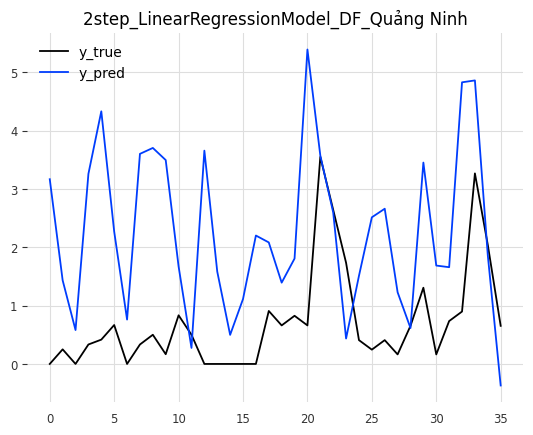

rmse,mae,mape,mse
2.1087279486751256,1.6963354824755699,1696288200135148.2,4.446733561523604
✨✨✨✨✨✨✨✨CatBoostModel✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨Bình Phước✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,learning_rate,n_estimators,max_depth,random_state,likelihood,quantiles,bagging_temperature,border_count,l2_leaf_reg,random_strength
0,Bình Phước,CatBoost,17.279378,1,4,"-2,-3,-4",1,0.043860,121,13,866,quantile,IsNone,6.237274,35,1.662029,1.422164
1,An Giang,CatBoost,7.282708,1,4,"-2,-3,-4",1,0.036977,106,4,441,quantile,"0.1,0.5,0.9",24.537491,95,1.307070,5.463057
2,Quảng Ninh,CatBoost,2.022887,1,4,"-2,-3,-4",1,0.044653,194,15,421,quantile,IsNone,37.736772,144,0.416235,2.933525


🐝Oát zúppppp
🐝Nà ní đa phắc
🐝Still fine
🐝Nee
mean_squared_error: 219.0066
rmse: 14.798871340277218
mape: 2.2886311686864165


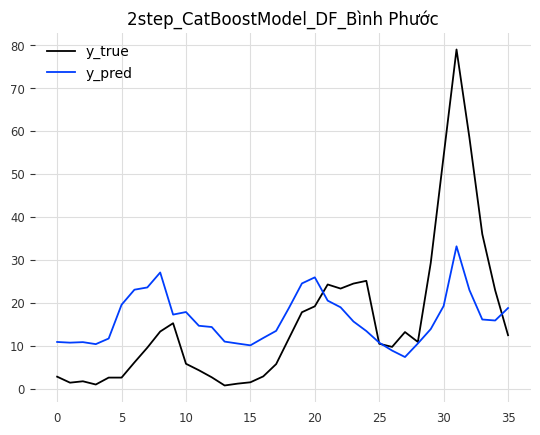

rmse,mae,mape,mse
14.798871340277218,11.355873584851627,2.2886311686864165,219.00659294607843
✨✨✨✨✨✨✨✨An Giang✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,learning_rate,n_estimators,max_depth,random_state,likelihood,quantiles,bagging_temperature,border_count,l2_leaf_reg,random_strength
0,Bình Phước,CatBoost,17.279378,1,4,"-2,-3,-4",1,0.043860,121,13,866,quantile,IsNone,6.237274,35,1.662029,1.422164
1,An Giang,CatBoost,7.282708,1,4,"-2,-3,-4",1,0.036977,106,4,441,quantile,"0.1,0.5,0.9",24.537491,95,1.307070,5.463057
2,Quảng Ninh,CatBoost,2.022887,1,4,"-2,-3,-4",1,0.044653,194,15,421,quantile,IsNone,37.736772,144,0.416235,2.933525


🐝Oát zúppppp
🐝Nà ní đa phắc
🐝Still fine
🐝Nee
mean_squared_error: 80.6568
rmse: 8.980914660021957
mape: 1.1160193098119817


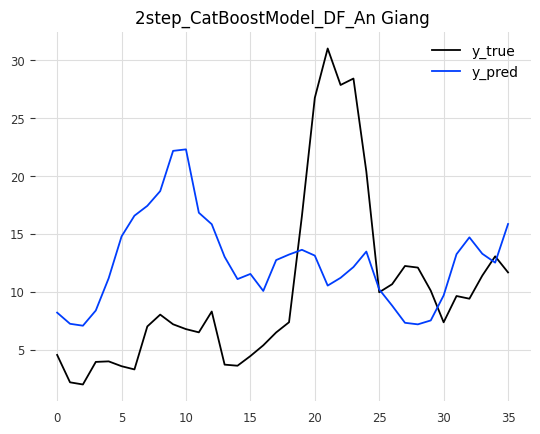

rmse,mae,mape,mse
8.980914660021957,7.473857015716362,1.1160193098119817,80.6568281305973
✨✨✨✨✨✨✨✨Quảng Ninh✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,learning_rate,n_estimators,max_depth,random_state,likelihood,quantiles,bagging_temperature,border_count,l2_leaf_reg,random_strength
0,Bình Phước,CatBoost,17.279378,1,4,"-2,-3,-4",1,0.043860,121,13,866,quantile,IsNone,6.237274,35,1.662029,1.422164
1,An Giang,CatBoost,7.282708,1,4,"-2,-3,-4",1,0.036977,106,4,441,quantile,"0.1,0.5,0.9",24.537491,95,1.307070,5.463057
2,Quảng Ninh,CatBoost,2.022887,1,4,"-2,-3,-4",1,0.044653,194,15,421,quantile,IsNone,37.736772,144,0.416235,2.933525


🐝Oát zúppppp
🐝Nà ní đa phắc
🐝Still fine
🐝Nee
mean_squared_error: 3.8741
rmse: 1.9682779649932873
mape: 1467609556689058.0


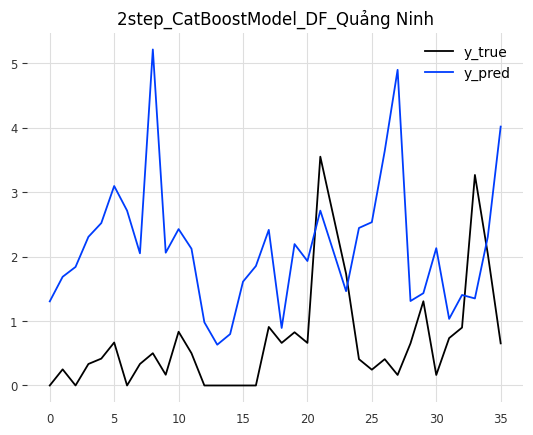

rmse,mae,mape,mse
1.9682779649932873,1.6285501931837192,1467609556689058.0,3.8741181474781166
✨✨✨✨✨✨✨✨XGBModel✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨Bình Phước✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,random_state,likelihood
0,Bình Phước,XGBModel,37.776471,1,4,"-2,-3,-4",1,30,quantile
1,An Giang,XGBModel,62.941766,1,4,"-2,-3,-4",1,11,quantile
2,Quảng Ninh,XGBModel,4.228871,1,4,"-2,-3,-4",1,5,quantile


🐝Oát zúppppp
🐝Nà ní đa phắc
🐝Still fine
🐝Nee
mean_squared_error: 2460.8378
rmse: 49.60683171139254
mape: 6.348124609539166


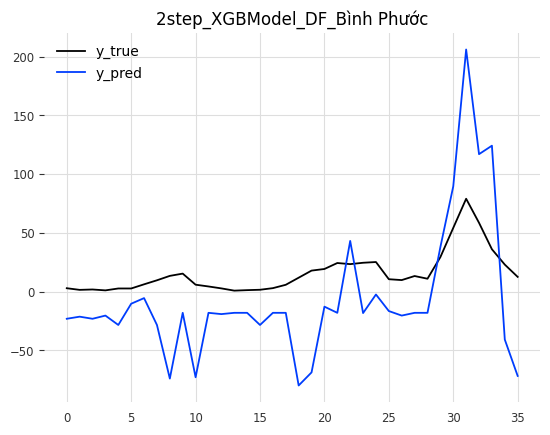

rmse,mae,mape,mse
49.60683171139254,40.89236054524113,6.348124609539166,2460.83775244242
✨✨✨✨✨✨✨✨An Giang✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,random_state,likelihood
0,Bình Phước,XGBModel,37.776471,1,4,"-2,-3,-4",1,30,quantile
1,An Giang,XGBModel,62.941766,1,4,"-2,-3,-4",1,11,quantile
2,Quảng Ninh,XGBModel,4.228871,1,4,"-2,-3,-4",1,5,quantile


🐝Oát zúppppp
🐝Nà ní đa phắc
🐝Still fine
🐝Nee
mean_squared_error: 1916.6461
rmse: 43.77951661911574
mape: 6.443460109785577


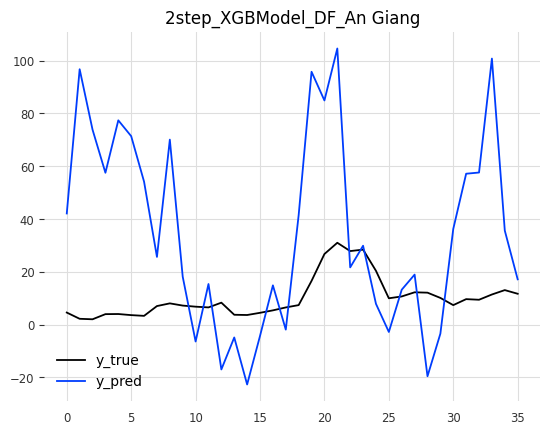

rmse,mae,mape,mse
43.77951661911574,34.02859574003378,6.443460109785577,1916.646075403431
✨✨✨✨✨✨✨✨Quảng Ninh✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,random_state,likelihood
0,Bình Phước,XGBModel,37.776471,1,4,"-2,-3,-4",1,30,quantile
1,An Giang,XGBModel,62.941766,1,4,"-2,-3,-4",1,11,quantile
2,Quảng Ninh,XGBModel,4.228871,1,4,"-2,-3,-4",1,5,quantile


🐝Oát zúppppp
🐝Nà ní đa phắc
🐝Still fine
🐝Nee
mean_squared_error: 27.4061
rmse: 5.2350788537227775
mape: 4400386990851418.5


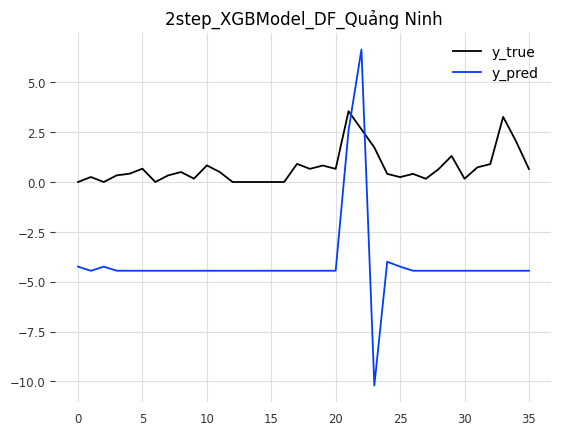

rmse,mae,mape,mse
5.2350788537227775,5.01735840430519,4400386990851418.5,27.406050604695388
✨✨✨✨✨✨✨✨3✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨RandomForest✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨Bình Phước✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,n_estimators,max_depth,random_state
0,Bình Phước,RandomForest,27.729699,1,5,"-3,-4,-5",1,58,10,42
1,An Giang,RandomForest,7.495862,1,5,"-3,-4,-5",1,60,13,25
2,Quảng Ninh,RandomForest,11.699743,1,5,"-3,-4,-5",1,155,6,20


🐝Oát zúppppp
🐝Nà ní đa phắc
🐝Still fine
🐝Nee
mean_squared_error: 281.3861
rmse: 16.77456573578054
mape: 3.3075357708200097


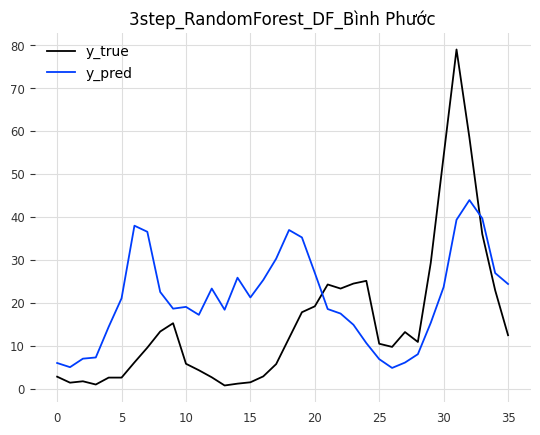

rmse,mae,mape,mse
16.77456573578054,13.846102062708928,3.3075357708200097,281.3860556240226
✨✨✨✨✨✨✨✨An Giang✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,n_estimators,max_depth,random_state
0,Bình Phước,RandomForest,27.729699,1,5,"-3,-4,-5",1,58,10,42
1,An Giang,RandomForest,7.495862,1,5,"-3,-4,-5",1,60,13,25
2,Quảng Ninh,RandomForest,11.699743,1,5,"-3,-4,-5",1,155,6,20


🐝Oát zúppppp
🐝Nà ní đa phắc
🐝Still fine
🐝Nee
mean_squared_error: 478.5584
rmse: 21.87597671783151
mape: 3.055979068634535


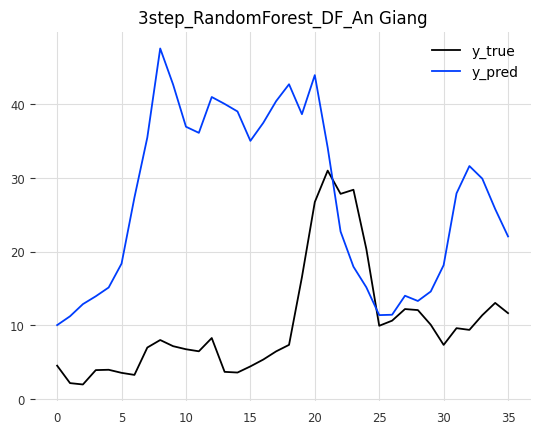

rmse,mae,mape,mse
21.87597671783151,18.08795124653271,3.055979068634535,478.5583573591063
✨✨✨✨✨✨✨✨Quảng Ninh✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,n_estimators,max_depth,random_state
0,Bình Phước,RandomForest,27.729699,1,5,"-3,-4,-5",1,58,10,42
1,An Giang,RandomForest,7.495862,1,5,"-3,-4,-5",1,60,13,25
2,Quảng Ninh,RandomForest,11.699743,1,5,"-3,-4,-5",1,155,6,20


🐝Oát zúppppp
🐝Nà ní đa phắc
🐝Still fine
🐝Nee
mean_squared_error: 98.7125
rmse: 9.935415953331448
mape: 8900448163814645.0


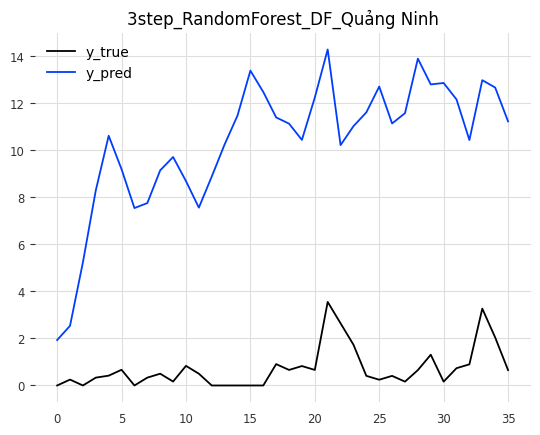

rmse,mae,mape,mse
9.935415953331448,9.594259102283887,8900448163814645.0,98.71249016571306
✨✨✨✨✨✨✨✨LinearRegressionModel✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨Bình Phước✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,random_state
0,Bình Phước,LinearRegressionModel,13.954101,1,5,"-3,-4,-5",1,3
1,An Giang,LinearRegressionModel,10.325255,1,5,"-3,-4,-5",1,42
2,Quảng Ninh,LinearRegressionModel,2.000336,1,5,"-3,-4,-5",1,14


🐝Oát zúppppp
🐝Nà ní đa phắc
🐝Still fine
🐝Nee
mean_squared_error: 302.4767
rmse: 17.391858426764507
mape: 2.861083927420058


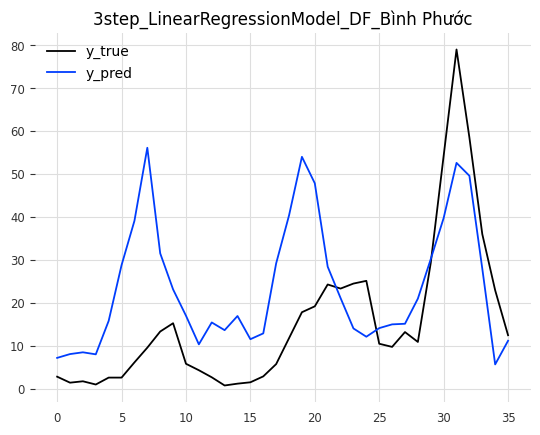

rmse,mae,mape,mse
17.391858426764507,13.69629602550743,2.861083927420058,302.47673953661956
✨✨✨✨✨✨✨✨An Giang✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,random_state
0,Bình Phước,LinearRegressionModel,13.954101,1,5,"-3,-4,-5",1,3
1,An Giang,LinearRegressionModel,10.325255,1,5,"-3,-4,-5",1,42
2,Quảng Ninh,LinearRegressionModel,2.000336,1,5,"-3,-4,-5",1,14


🐝Oát zúppppp
🐝Nà ní đa phắc
🐝Still fine
🐝Nee
mean_squared_error: 152.3325
rmse: 12.342304492031591
mape: 1.788989555655957


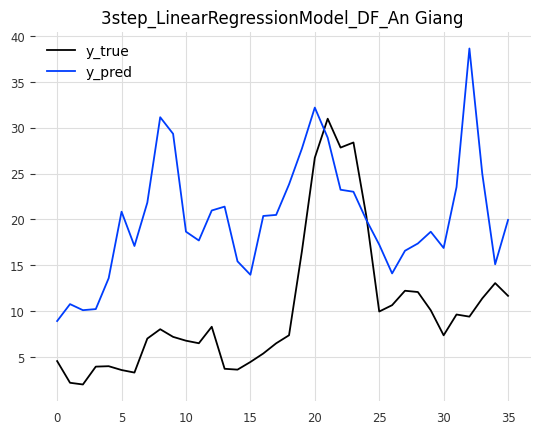

rmse,mae,mape,mse
12.342304492031591,10.645827807948233,1.788989555655957,152.3324801740232
✨✨✨✨✨✨✨✨Quảng Ninh✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,random_state
0,Bình Phước,LinearRegressionModel,13.954101,1,5,"-3,-4,-5",1,3
1,An Giang,LinearRegressionModel,10.325255,1,5,"-3,-4,-5",1,42
2,Quảng Ninh,LinearRegressionModel,2.000336,1,5,"-3,-4,-5",1,14


🐝Oát zúppppp
🐝Nà ní đa phắc
🐝Still fine
🐝Nee
mean_squared_error: 2.8666
rmse: 1.6930958249968109
mape: 866593664582826.9


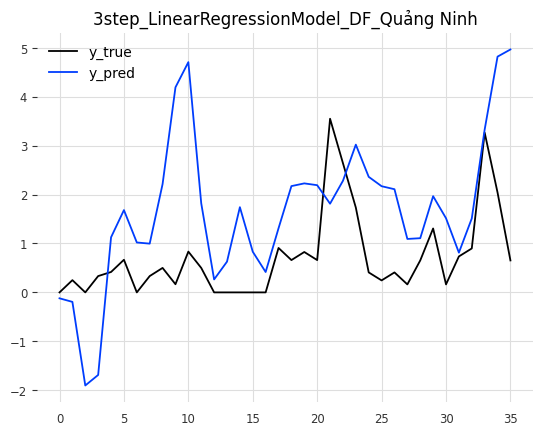

rmse,mae,mape,mse
1.6930958249968109,1.3267914792161895,866593664582826.9,2.8665734726216314
✨✨✨✨✨✨✨✨CatBoostModel✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨Bình Phước✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,learning_rate,n_estimators,max_depth,random_state,likelihood,quantiles,bagging_temperature,border_count,l2_leaf_reg,random_strength
0,Bình Phước,CatBoost,19.341460,1,5,"-3,-4,-5",1,0.002516,152,14,499,quantile,"0.1,0.5,0.9",64.963477,241,4.542673,8.810665
1,An Giang,CatBoost,8.122722,1,5,"-3,-4,-5",1,0.092870,57,7,479,quantile,"0.1,0.5,0.9",23.461482,186,6.739463,0.581838
2,Quảng Ninh,CatBoost,1.923374,1,5,"-3,-4,-5",1,0.059058,130,1,147,quantile,"0.1,0.5,0.9",91.316523,94,7.099162,4.036061


🐝Oát zúppppp
🐝Nà ní đa phắc
🐝Still fine
🐝Nee
mean_squared_error: 288.4110
rmse: 16.982667315088413
mape: 2.5363214892916255


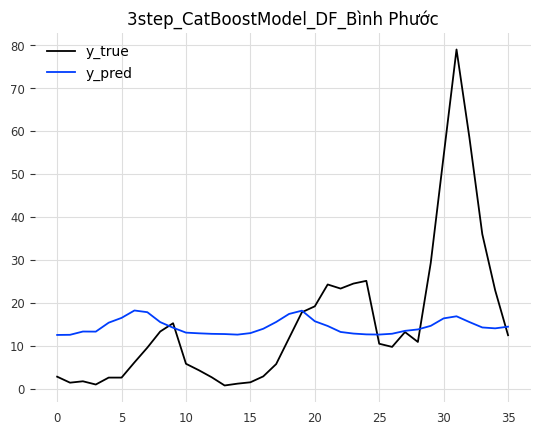

rmse,mae,mape,mse
16.982667315088413,11.900613546863877,2.5363214892916255,288.41098913497234
✨✨✨✨✨✨✨✨An Giang✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,learning_rate,n_estimators,max_depth,random_state,likelihood,quantiles,bagging_temperature,border_count,l2_leaf_reg,random_strength
0,Bình Phước,CatBoost,19.341460,1,5,"-3,-4,-5",1,0.002516,152,14,499,quantile,"0.1,0.5,0.9",64.963477,241,4.542673,8.810665
1,An Giang,CatBoost,8.122722,1,5,"-3,-4,-5",1,0.092870,57,7,479,quantile,"0.1,0.5,0.9",23.461482,186,6.739463,0.581838
2,Quảng Ninh,CatBoost,1.923374,1,5,"-3,-4,-5",1,0.059058,130,1,147,quantile,"0.1,0.5,0.9",91.316523,94,7.099162,4.036061


🐝Oát zúppppp
🐝Nà ní đa phắc
🐝Still fine
🐝Nee
mean_squared_error: 318.1961
rmse: 17.838052350814966
mape: 2.2671287870469157


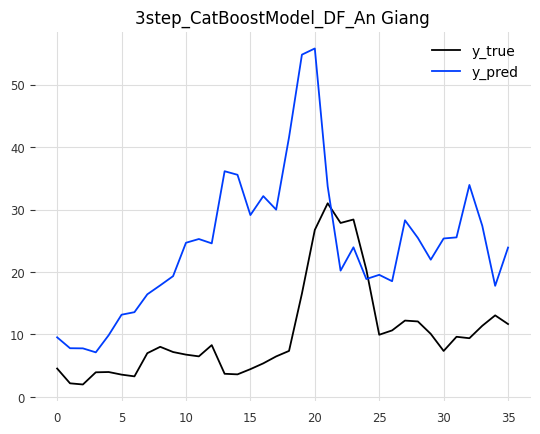

rmse,mae,mape,mse
17.838052350814966,14.916032240001433,2.2671287870469157,318.19611167041535
✨✨✨✨✨✨✨✨Quảng Ninh✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,learning_rate,n_estimators,max_depth,random_state,likelihood,quantiles,bagging_temperature,border_count,l2_leaf_reg,random_strength
0,Bình Phước,CatBoost,19.341460,1,5,"-3,-4,-5",1,0.002516,152,14,499,quantile,"0.1,0.5,0.9",64.963477,241,4.542673,8.810665
1,An Giang,CatBoost,8.122722,1,5,"-3,-4,-5",1,0.092870,57,7,479,quantile,"0.1,0.5,0.9",23.461482,186,6.739463,0.581838
2,Quảng Ninh,CatBoost,1.923374,1,5,"-3,-4,-5",1,0.059058,130,1,147,quantile,"0.1,0.5,0.9",91.316523,94,7.099162,4.036061


🐝Oát zúppppp
🐝Nà ní đa phắc
🐝Still fine
🐝Nee
mean_squared_error: 2.3186
rmse: 1.5226812515011923
mape: 1778279101556148.8


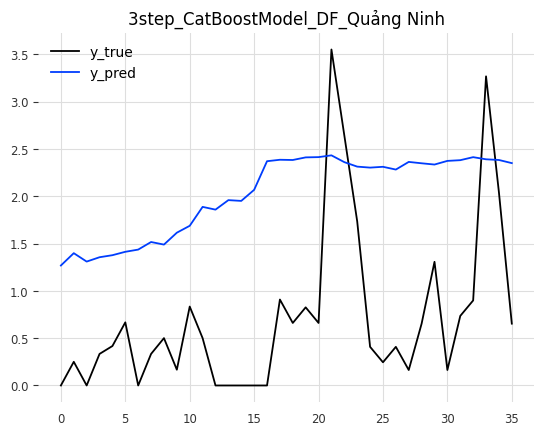

rmse,mae,mape,mse
1.5226812515011923,1.4304511984713462,1778279101556148.8,2.318558193673237
✨✨✨✨✨✨✨✨XGBModel✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨Bình Phước✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,random_state,likelihood
0,Bình Phước,XGBModel,49.042674,1,5,"-3,-4,-5",1,36,quantile
1,An Giang,XGBModel,19.292724,1,5,"-3,-4,-5",1,19,quantile
2,Quảng Ninh,XGBModel,5.412962,1,5,"-3,-4,-5",1,41,quantile


🐝Oát zúppppp
🐝Nà ní đa phắc
🐝Still fine
🐝Nee
mean_squared_error: 2583.7218
rmse: 50.83032372309633
mape: 6.013958792538201


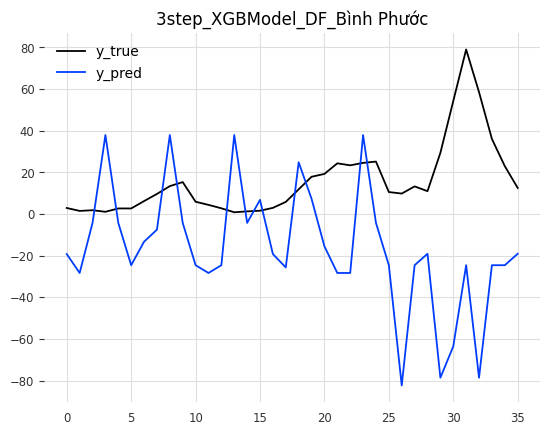

rmse,mae,mape,mse
50.83032372309633,39.14972594051404,6.013958792538201,2583.7218097947693
✨✨✨✨✨✨✨✨An Giang✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,random_state,likelihood
0,Bình Phước,XGBModel,49.042674,1,5,"-3,-4,-5",1,36,quantile
1,An Giang,XGBModel,19.292724,1,5,"-3,-4,-5",1,19,quantile
2,Quảng Ninh,XGBModel,5.412962,1,5,"-3,-4,-5",1,41,quantile


🐝Oát zúppppp
🐝Nà ní đa phắc
🐝Still fine
🐝Nee
mean_squared_error: 1994.4614
rmse: 44.65939283012492
mape: 5.7112491528461184


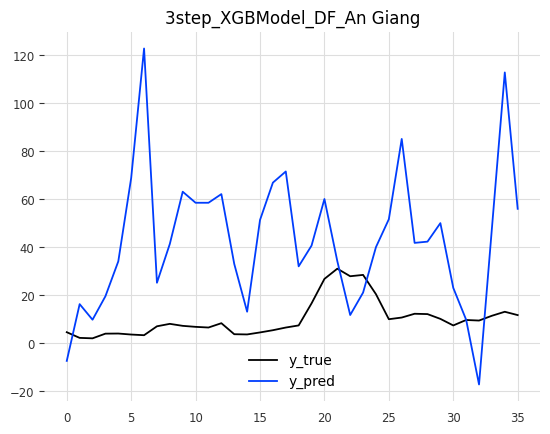

rmse,mae,mape,mse
44.65939283012492,36.3044755885307,5.7112491528461184,1994.4613679554136
✨✨✨✨✨✨✨✨Quảng Ninh✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,random_state,likelihood
0,Bình Phước,XGBModel,49.042674,1,5,"-3,-4,-5",1,36,quantile
1,An Giang,XGBModel,19.292724,1,5,"-3,-4,-5",1,19,quantile
2,Quảng Ninh,XGBModel,5.412962,1,5,"-3,-4,-5",1,41,quantile


🐝Oát zúppppp
🐝Nà ní đa phắc
🐝Still fine
🐝Nee
mean_squared_error: 33.1853
rmse: 5.760671986361972
mape: 4937782950423550.0


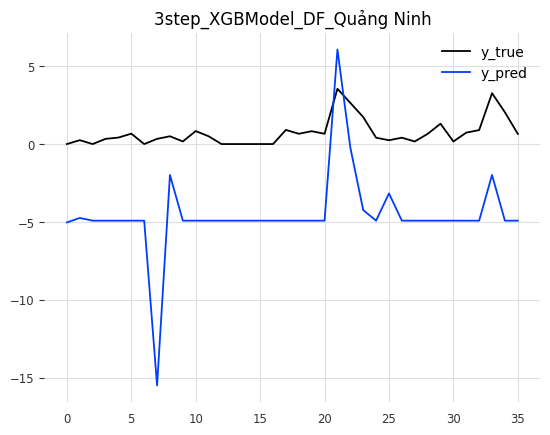

rmse,mae,mape,mse
5.760671986361972,5.405838700602342,4937782950423550.0,33.185341734455584
✨✨✨✨✨✨✨✨4✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨RandomForest✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨Bình Phước✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,n_estimators,max_depth,random_state
0,Bình Phước,RandomForest,18.951460,1,6,"-4,-5,-6",1,65,7,17
1,An Giang,RandomForest,9.493649,1,6,"-4,-5,-6",1,200,12,8
2,Quảng Ninh,RandomForest,7.528306,1,6,"-4,-5,-6",1,177,7,28


🐝Oát zúppppp
🐝Nà ní đa phắc
🐝Still fine
🐝Nee
mean_squared_error: 329.5129
rmse: 18.152489817578513
mape: 3.716647631571676


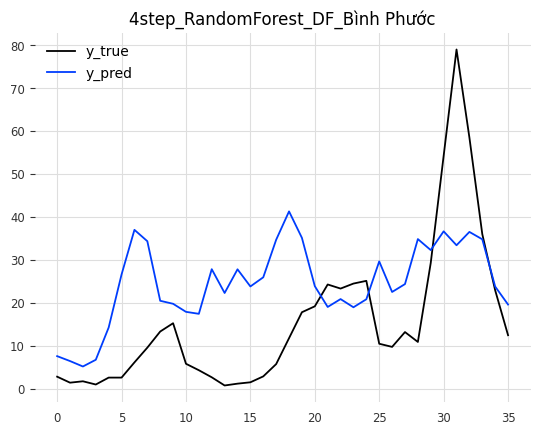

rmse,mae,mape,mse
18.152489817578513,14.668641012043572,3.716647631571676,329.5128865772916
✨✨✨✨✨✨✨✨An Giang✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,n_estimators,max_depth,random_state
0,Bình Phước,RandomForest,18.951460,1,6,"-4,-5,-6",1,65,7,17
1,An Giang,RandomForest,9.493649,1,6,"-4,-5,-6",1,200,12,8
2,Quảng Ninh,RandomForest,7.528306,1,6,"-4,-5,-6",1,177,7,28


🐝Oát zúppppp
🐝Nà ní đa phắc
🐝Still fine
🐝Nee
mean_squared_error: 110.9715
rmse: 10.534303009149086
mape: 1.5142053473437598


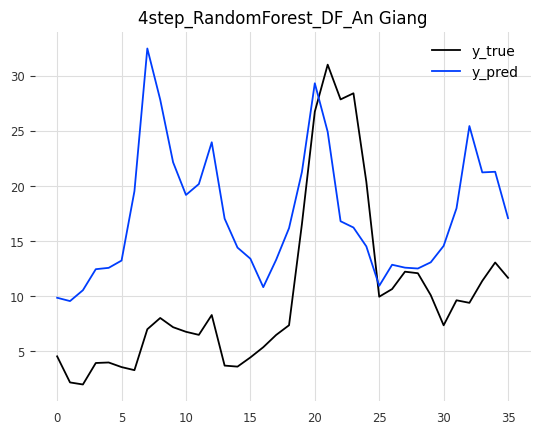

rmse,mae,mape,mse
10.534303009149086,9.022813167036354,1.5142053473437598,110.97153988856749
✨✨✨✨✨✨✨✨Quảng Ninh✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,n_estimators,max_depth,random_state
0,Bình Phước,RandomForest,18.951460,1,6,"-4,-5,-6",1,65,7,17
1,An Giang,RandomForest,9.493649,1,6,"-4,-5,-6",1,200,12,8
2,Quảng Ninh,RandomForest,7.528306,1,6,"-4,-5,-6",1,177,7,28


🐝Oát zúppppp
🐝Nà ní đa phắc
🐝Still fine
🐝Nee
mean_squared_error: 101.8389
rmse: 10.091527796159776
mape: 1.0251332533829606e+16


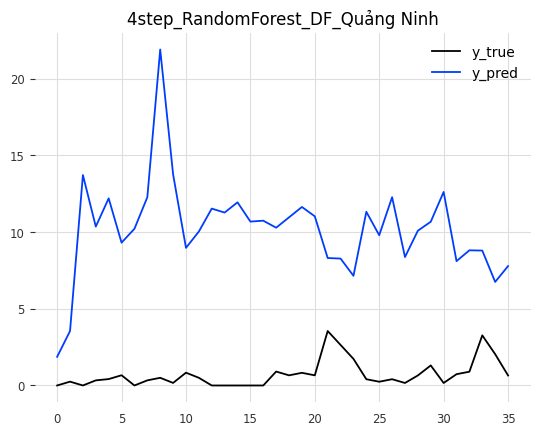

rmse,mae,mape,mse
10.091527796159776,9.481189495811709,1.0251332533829606e+16,101.83893326066537
✨✨✨✨✨✨✨✨LinearRegressionModel✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨Bình Phước✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,random_state
0,Bình Phước,LinearRegressionModel,16.639590,1,6,"-4,-5,-6",1,35
1,An Giang,LinearRegressionModel,12.048996,1,6,"-4,-5,-6",1,30
2,Quảng Ninh,LinearRegressionModel,2.014932,1,6,"-4,-5,-6",1,3


🐝Oát zúppppp
🐝Nà ní đa phắc
🐝Still fine
🐝Nee
mean_squared_error: 306.0556
rmse: 17.494443556789793
mape: 3.2493149928349467


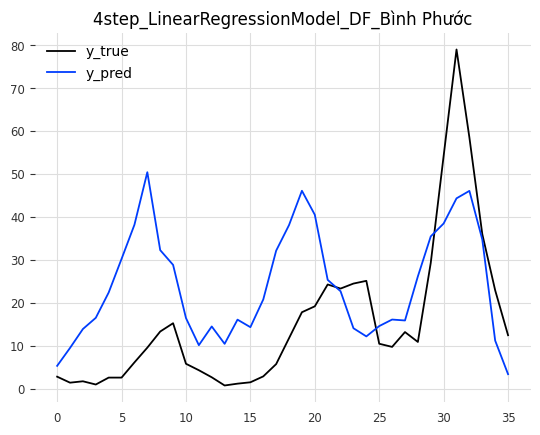

rmse,mae,mape,mse
17.494443556789793,14.484846373187708,3.2493149928349467,306.05555536170397
✨✨✨✨✨✨✨✨An Giang✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,random_state
0,Bình Phước,LinearRegressionModel,16.639590,1,6,"-4,-5,-6",1,35
1,An Giang,LinearRegressionModel,12.048996,1,6,"-4,-5,-6",1,30
2,Quảng Ninh,LinearRegressionModel,2.014932,1,6,"-4,-5,-6",1,3


🐝Oát zúppppp
🐝Nà ní đa phắc
🐝Still fine
🐝Nee
mean_squared_error: 110.1778
rmse: 10.496559853154205
mape: 1.5245214216082605


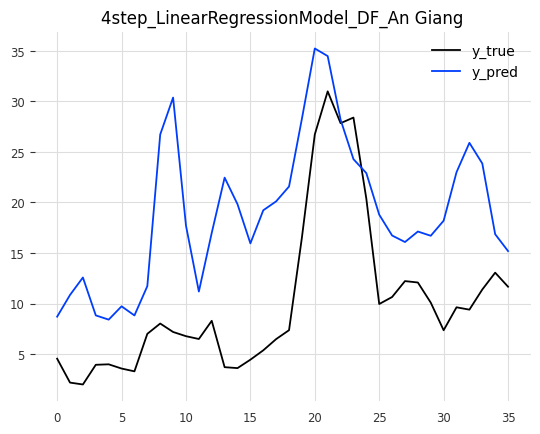

rmse,mae,mape,mse
10.496559853154205,9.033686158145969,1.5245214216082605,110.17776875084863
✨✨✨✨✨✨✨✨Quảng Ninh✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,random_state
0,Bình Phước,LinearRegressionModel,16.639590,1,6,"-4,-5,-6",1,35
1,An Giang,LinearRegressionModel,12.048996,1,6,"-4,-5,-6",1,30
2,Quảng Ninh,LinearRegressionModel,2.014932,1,6,"-4,-5,-6",1,3


🐝Oát zúppppp
🐝Nà ní đa phắc
🐝Still fine
🐝Nee
mean_squared_error: 2.5324
rmse: 1.5913422509770252
mape: 1610578261657143.5


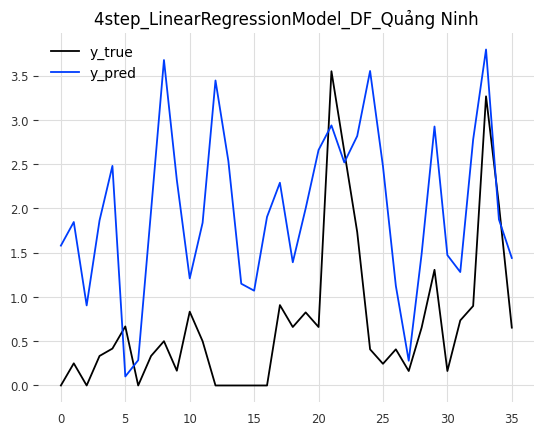

rmse,mae,mape,mse
1.5913422509770252,1.341556146740839,1610578261657143.5,2.5323701597446258
✨✨✨✨✨✨✨✨CatBoostModel✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨Bình Phước✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,learning_rate,n_estimators,max_depth,random_state,likelihood,quantiles,bagging_temperature,border_count,l2_leaf_reg,random_strength
0,Bình Phước,CatBoost,17.819468,1,6,"-4,-5,-6",1,0.019284,172,15,629,quantile,"0.1,0.5,0.9",38.186873,123,7.874137,5.798526
1,An Giang,CatBoost,7.784587,1,6,"-4,-5,-6",1,0.001687,113,8,148,quantile,IsNone,58.421095,112,8.089094,8.832055
2,Quảng Ninh,CatBoost,7.275636,1,6,"-4,-5,-6",1,0.086892,108,4,607,quantile,"0.1,0.5,0.9",82.843123,197,0.464891,5.651930


🐝Oát zúppppp
🐝Nà ní đa phắc
🐝Still fine
🐝Nee
mean_squared_error: 215.8803
rmse: 14.69286697697894
mape: 2.130119337136348


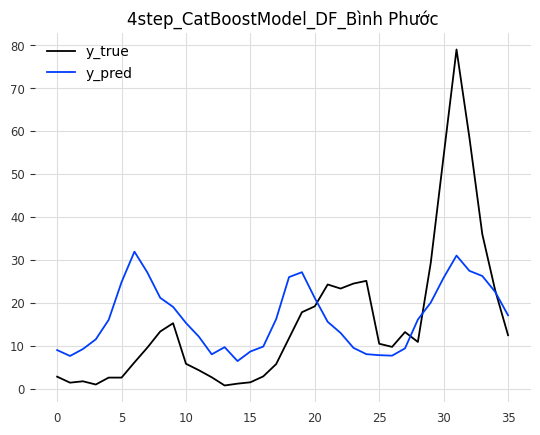

rmse,mae,mape,mse
14.69286697697894,11.219710115868216,2.130119337136348,215.88034000319826
✨✨✨✨✨✨✨✨An Giang✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,learning_rate,n_estimators,max_depth,random_state,likelihood,quantiles,bagging_temperature,border_count,l2_leaf_reg,random_strength
0,Bình Phước,CatBoost,17.819468,1,6,"-4,-5,-6",1,0.019284,172,15,629,quantile,"0.1,0.5,0.9",38.186873,123,7.874137,5.798526
1,An Giang,CatBoost,7.784587,1,6,"-4,-5,-6",1,0.001687,113,8,148,quantile,IsNone,58.421095,112,8.089094,8.832055
2,Quảng Ninh,CatBoost,7.275636,1,6,"-4,-5,-6",1,0.086892,108,4,607,quantile,"0.1,0.5,0.9",82.843123,197,0.464891,5.651930


🐝Oát zúppppp
🐝Nà ní đa phắc
🐝Still fine
🐝Nee
mean_squared_error: 59.9849
rmse: 7.744994743167081
mape: 1.0595471669964949


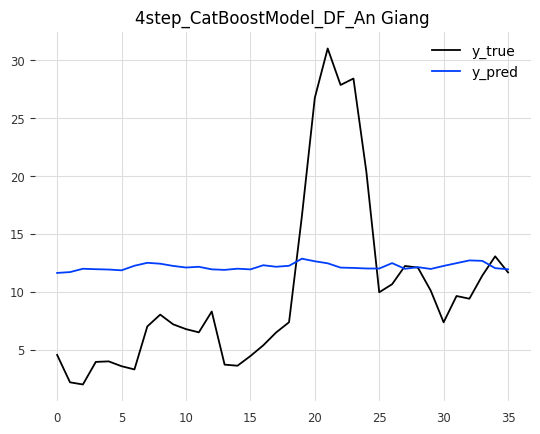

rmse,mae,mape,mse
7.744994743167081,6.310600610207404,1.0595471669964949,59.98494357168571
✨✨✨✨✨✨✨✨Quảng Ninh✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,learning_rate,n_estimators,max_depth,random_state,likelihood,quantiles,bagging_temperature,border_count,l2_leaf_reg,random_strength
0,Bình Phước,CatBoost,17.819468,1,6,"-4,-5,-6",1,0.019284,172,15,629,quantile,"0.1,0.5,0.9",38.186873,123,7.874137,5.798526
1,An Giang,CatBoost,7.784587,1,6,"-4,-5,-6",1,0.001687,113,8,148,quantile,IsNone,58.421095,112,8.089094,8.832055
2,Quảng Ninh,CatBoost,7.275636,1,6,"-4,-5,-6",1,0.086892,108,4,607,quantile,"0.1,0.5,0.9",82.843123,197,0.464891,5.651930


🐝Oát zúppppp
🐝Nà ní đa phắc
🐝Still fine
🐝Nee
mean_squared_error: 22.8090
rmse: 4.775880892410975
mape: 4404861789379410.5


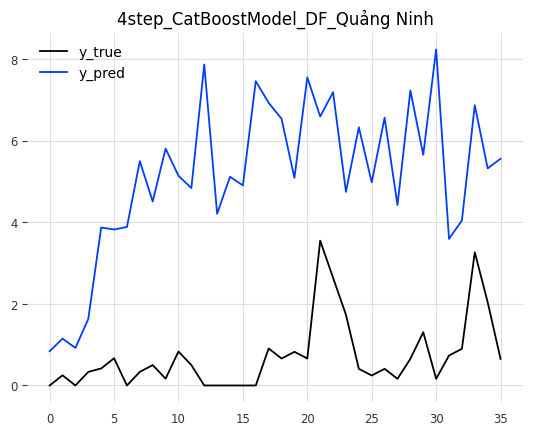

rmse,mae,mape,mse
4.775880892410975,4.417631169107356,4404861789379410.5,22.809038298496255
✨✨✨✨✨✨✨✨XGBModel✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨Bình Phước✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,random_state,likelihood
0,Bình Phước,XGBModel,33.321670,1,6,"-4,-5,-6",1,14,quantile
1,An Giang,XGBModel,42.195607,1,6,"-4,-5,-6",1,43,quantile
2,Quảng Ninh,XGBModel,5.914793,1,6,"-4,-5,-6",1,42,quantile


🐝Oát zúppppp
🐝Nà ní đa phắc
🐝Still fine
🐝Nee
mean_squared_error: 2366.9150
rmse: 48.65095090584238
mape: 8.032211426514323


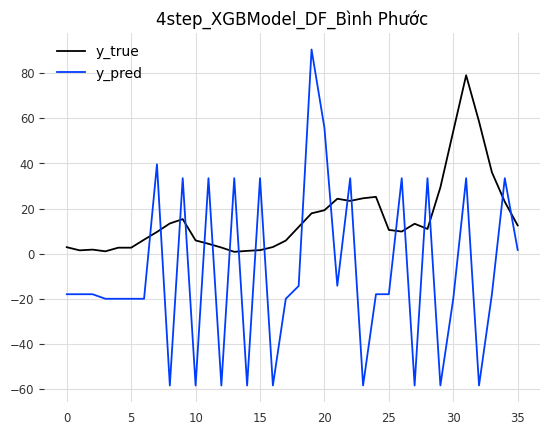

rmse,mae,mape,mse
48.65095090584238,41.496577525653585,8.032211426514323,2366.915024042685
✨✨✨✨✨✨✨✨An Giang✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,random_state,likelihood
0,Bình Phước,XGBModel,33.321670,1,6,"-4,-5,-6",1,14,quantile
1,An Giang,XGBModel,42.195607,1,6,"-4,-5,-6",1,43,quantile
2,Quảng Ninh,XGBModel,5.914793,1,6,"-4,-5,-6",1,42,quantile


🐝Oát zúppppp
🐝Nà ní đa phắc
🐝Still fine
🐝Nee
mean_squared_error: 4442.0243
rmse: 66.64851297459367
mape: 7.933711740345583


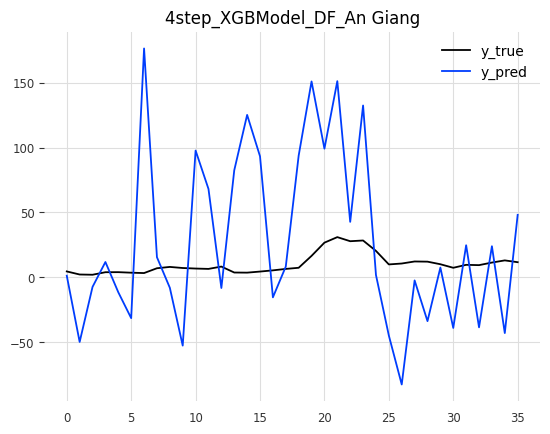

rmse,mae,mape,mse
66.64851297459367,51.07209476622929,7.933711740345583,4442.024281724581
✨✨✨✨✨✨✨✨Quảng Ninh✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,random_state,likelihood
0,Bình Phước,XGBModel,33.321670,1,6,"-4,-5,-6",1,14,quantile
1,An Giang,XGBModel,42.195607,1,6,"-4,-5,-6",1,43,quantile
2,Quảng Ninh,XGBModel,5.914793,1,6,"-4,-5,-6",1,42,quantile


🐝Oát zúppppp
🐝Nà ní đa phắc
🐝Still fine
🐝Nee
mean_squared_error: 62.2615
rmse: 7.8905938063290675
mape: 4337770854785174.0


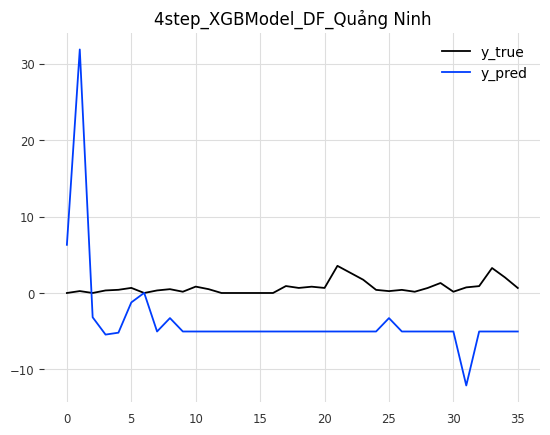

rmse,mae,mape,mse
7.8905938063290675,6.339501852027049,4337770854785174.0,62.26147061647865
✨✨✨✨✨✨✨✨5✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨RandomForest✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨Bình Phước✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,n_estimators,max_depth,random_state
0,Bình Phước,RandomForest,20.221948,1,7,"-5,-6,-7",1,66,1,4
1,An Giang,RandomForest,9.336510,1,7,"-5,-6,-7",1,54,11,6
2,Quảng Ninh,RandomForest,11.163617,1,7,"-5,-6,-7",1,99,12,10


🐝Oát zúppppp
🐝Nà ní đa phắc
🐝Still fine
🐝Nee
mean_squared_error: 305.4216
rmse: 17.47631564803764
mape: 3.273715141808545


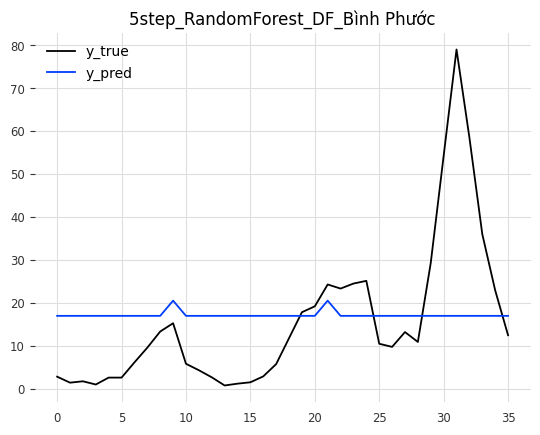

rmse,mae,mape,mse
17.47631564803764,12.99339028174502,3.273715141808545,305.42160862984525
✨✨✨✨✨✨✨✨An Giang✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,n_estimators,max_depth,random_state
0,Bình Phước,RandomForest,20.221948,1,7,"-5,-6,-7",1,66,1,4
1,An Giang,RandomForest,9.336510,1,7,"-5,-6,-7",1,54,11,6
2,Quảng Ninh,RandomForest,11.163617,1,7,"-5,-6,-7",1,99,12,10


🐝Oát zúppppp
🐝Nà ní đa phắc
🐝Still fine
🐝Nee
mean_squared_error: 609.1817
rmse: 24.681605821366073
mape: 2.9931712022464803


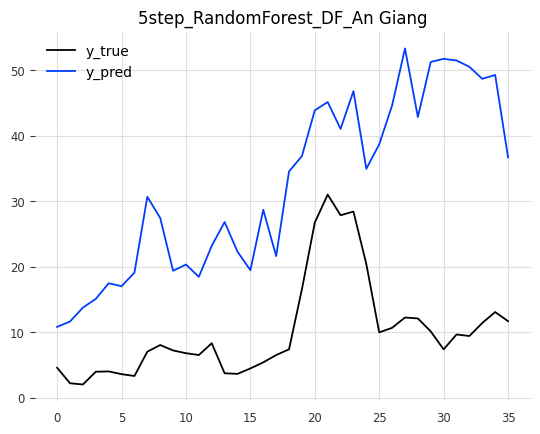

rmse,mae,mape,mse
24.681605821366073,22.18243110796667,2.9931712022464803,609.1816659212916
✨✨✨✨✨✨✨✨Quảng Ninh✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,n_estimators,max_depth,random_state
0,Bình Phước,RandomForest,20.221948,1,7,"-5,-6,-7",1,66,1,4
1,An Giang,RandomForest,9.336510,1,7,"-5,-6,-7",1,54,11,6
2,Quảng Ninh,RandomForest,11.163617,1,7,"-5,-6,-7",1,99,12,10


🐝Oát zúppppp
🐝Nà ní đa phắc
🐝Still fine
🐝Nee
mean_squared_error: 104.0823
rmse: 10.202074812336202
mape: 9261279535710030.0


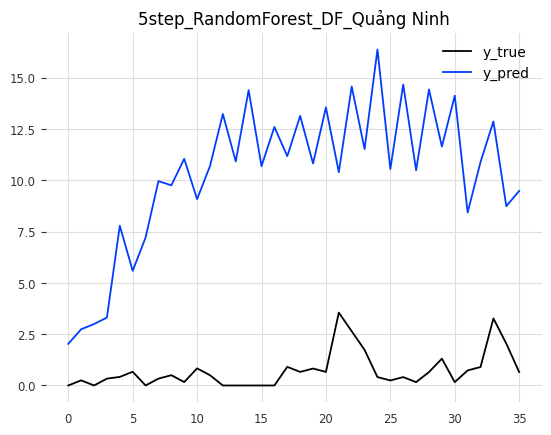

rmse,mae,mape,mse
10.202074812336202,9.605417126993382,9261279535710030.0,104.08233047650474
✨✨✨✨✨✨✨✨LinearRegressionModel✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨Bình Phước✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,random_state
0,Bình Phước,LinearRegressionModel,17.510178,1,7,"-5,-6,-7",1,9
1,An Giang,LinearRegressionModel,9.455692,1,7,"-5,-6,-7",1,12
2,Quảng Ninh,LinearRegressionModel,1.990581,1,7,"-5,-6,-7",1,39


🐝Oát zúppppp
🐝Nà ní đa phắc
🐝Still fine
🐝Nee
mean_squared_error: 276.1651
rmse: 16.618216408479785
mape: 2.34713822236065


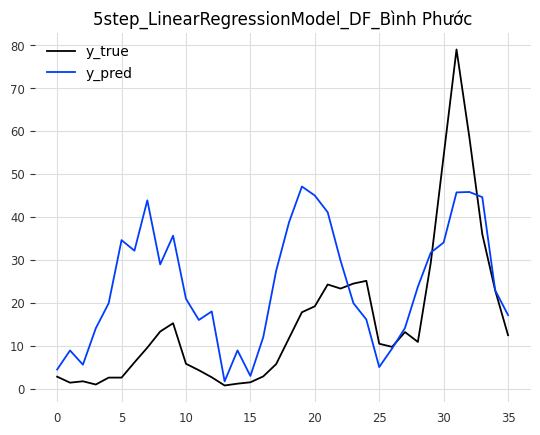

rmse,mae,mape,mse
16.618216408479785,13.196446763782056,2.34713822236065,276.1651165990667
✨✨✨✨✨✨✨✨An Giang✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,random_state
0,Bình Phước,LinearRegressionModel,17.510178,1,7,"-5,-6,-7",1,9
1,An Giang,LinearRegressionModel,9.455692,1,7,"-5,-6,-7",1,12
2,Quảng Ninh,LinearRegressionModel,1.990581,1,7,"-5,-6,-7",1,39


🐝Oát zúppppp
🐝Nà ní đa phắc
🐝Still fine
🐝Nee
mean_squared_error: 155.8036
rmse: 12.482130315448206
mape: 1.7307355461402052


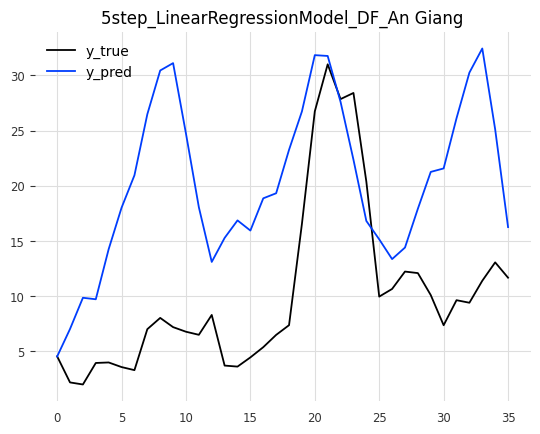

rmse,mae,mape,mse
12.482130315448206,10.599352955078263,1.7307355461402052,155.8035772118311
✨✨✨✨✨✨✨✨Quảng Ninh✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,random_state
0,Bình Phước,LinearRegressionModel,17.510178,1,7,"-5,-6,-7",1,9
1,An Giang,LinearRegressionModel,9.455692,1,7,"-5,-6,-7",1,12
2,Quảng Ninh,LinearRegressionModel,1.990581,1,7,"-5,-6,-7",1,39


🐝Oát zúppppp
🐝Nà ní đa phắc
🐝Still fine
🐝Nee
mean_squared_error: 3.2133
rmse: 1.7925804205438172
mape: 1630710814151182.2


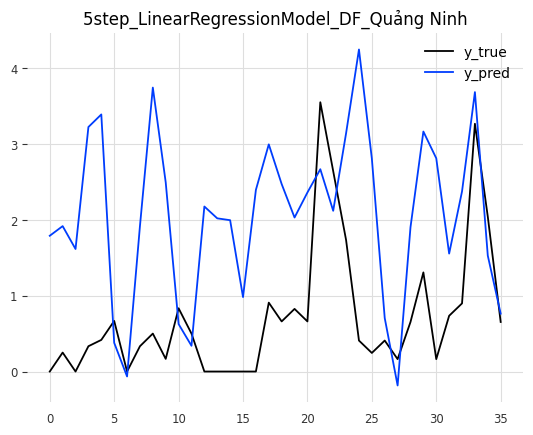

rmse,mae,mape,mse
1.7925804205438172,1.5034558661158768,1630710814151182.2,3.2133445641170484
✨✨✨✨✨✨✨✨CatBoostModel✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨Bình Phước✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,learning_rate,n_estimators,max_depth,random_state,likelihood,quantiles,bagging_temperature,border_count,l2_leaf_reg,random_strength
0,Bình Phước,CatBoost,19.454901,1,7,"-5,-6,-7",1,0.097970,173,12,960,quantile,IsNone,43.387537,250,0.882292,0.834956
1,An Giang,CatBoost,9.327746,1,7,"-5,-6,-7",1,0.095927,141,11,226,quantile,IsNone,64.434384,56,1.617408,3.459281
2,Quảng Ninh,CatBoost,4.193099,1,7,"-5,-6,-7",1,0.075375,124,11,670,quantile,IsNone,45.370735,64,8.143384,1.866469


🐝Oát zúppppp
🐝Nà ní đa phắc
🐝Still fine
🐝Nee
mean_squared_error: 258.2749
rmse: 16.070933066369637
mape: 2.6526303502536464


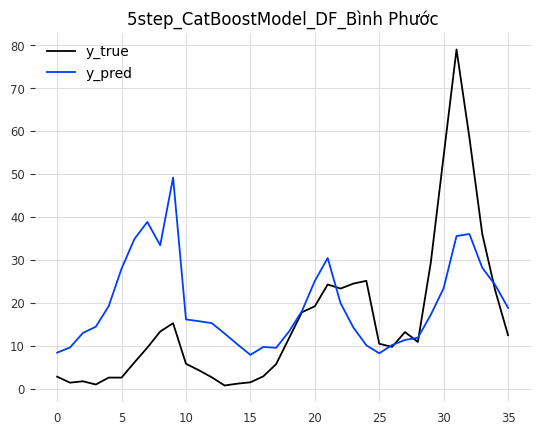

rmse,mae,mape,mse
16.070933066369637,12.143715150779935,2.6526303502536464,258.274889623733
✨✨✨✨✨✨✨✨An Giang✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,learning_rate,n_estimators,max_depth,random_state,likelihood,quantiles,bagging_temperature,border_count,l2_leaf_reg,random_strength
0,Bình Phước,CatBoost,19.454901,1,7,"-5,-6,-7",1,0.097970,173,12,960,quantile,IsNone,43.387537,250,0.882292,0.834956
1,An Giang,CatBoost,9.327746,1,7,"-5,-6,-7",1,0.095927,141,11,226,quantile,IsNone,64.434384,56,1.617408,3.459281
2,Quảng Ninh,CatBoost,4.193099,1,7,"-5,-6,-7",1,0.075375,124,11,670,quantile,IsNone,45.370735,64,8.143384,1.866469


🐝Oát zúppppp
🐝Nà ní đa phắc
🐝Still fine
🐝Nee
mean_squared_error: 117.3021
rmse: 10.83061131830795
mape: 1.3972609735856782


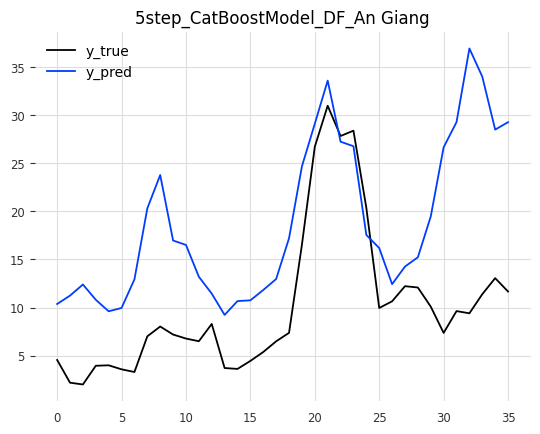

rmse,mae,mape,mse
10.83061131830795,8.803380275802597,1.3972609735856782,117.30214152826028
✨✨✨✨✨✨✨✨Quảng Ninh✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,learning_rate,n_estimators,max_depth,random_state,likelihood,quantiles,bagging_temperature,border_count,l2_leaf_reg,random_strength
0,Bình Phước,CatBoost,19.454901,1,7,"-5,-6,-7",1,0.097970,173,12,960,quantile,IsNone,43.387537,250,0.882292,0.834956
1,An Giang,CatBoost,9.327746,1,7,"-5,-6,-7",1,0.095927,141,11,226,quantile,IsNone,64.434384,56,1.617408,3.459281
2,Quảng Ninh,CatBoost,4.193099,1,7,"-5,-6,-7",1,0.075375,124,11,670,quantile,IsNone,45.370735,64,8.143384,1.866469


🐝Oát zúppppp
🐝Nà ní đa phắc
🐝Still fine
🐝Nee
mean_squared_error: 20.1828
rmse: 4.492528802730194
mape: 4378476142428258.0


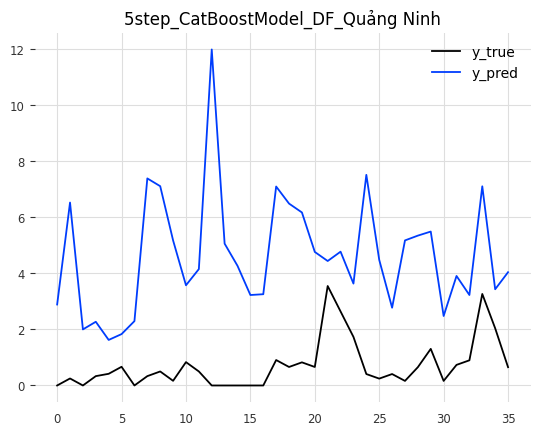

rmse,mae,mape,mse
4.492528802730194,3.920554162970785,4378476142428258.0,20.182815043360392
✨✨✨✨✨✨✨✨XGBModel✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨Bình Phước✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,random_state,likelihood
0,Bình Phước,XGBModel,42.237182,1,7,"-5,-6,-7",1,41,quantile
1,An Giang,XGBModel,39.323421,1,7,"-5,-6,-7",1,30,quantile
2,Quảng Ninh,XGBModel,5.305782,1,7,"-5,-6,-7",1,41,quantile


🐝Oát zúppppp
🐝Nà ní đa phắc
🐝Still fine
🐝Nee
mean_squared_error: 1445.9322
rmse: 38.025415839040576
mape: 5.631846823887454


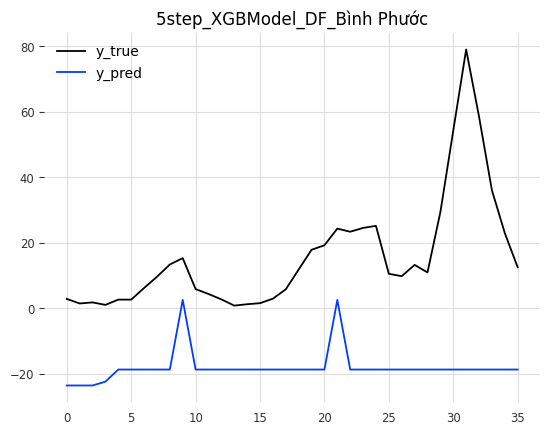

rmse,mae,mape,mse
38.025415839040576,33.74291044976357,5.631846823887454,1445.932249731958
✨✨✨✨✨✨✨✨An Giang✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,random_state,likelihood
0,Bình Phước,XGBModel,42.237182,1,7,"-5,-6,-7",1,41,quantile
1,An Giang,XGBModel,39.323421,1,7,"-5,-6,-7",1,30,quantile
2,Quảng Ninh,XGBModel,5.305782,1,7,"-5,-6,-7",1,41,quantile


🐝Oát zúppppp
🐝Nà ní đa phắc
🐝Still fine
🐝Nee
mean_squared_error: 1778.1888
rmse: 42.16857575766047
mape: 4.732498209924145


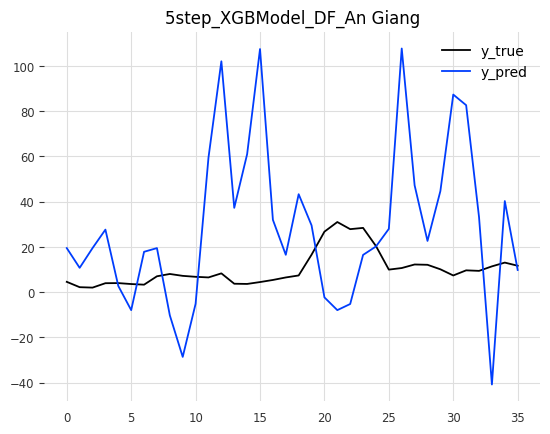

rmse,mae,mape,mse
42.16857575766047,32.32510303851208,4.732498209924145,1778.1887814295505
✨✨✨✨✨✨✨✨Quảng Ninh✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,random_state,likelihood
0,Bình Phước,XGBModel,42.237182,1,7,"-5,-6,-7",1,41,quantile
1,An Giang,XGBModel,39.323421,1,7,"-5,-6,-7",1,30,quantile
2,Quảng Ninh,XGBModel,5.305782,1,7,"-5,-6,-7",1,41,quantile


🐝Oát zúppppp
🐝Nà ní đa phắc
🐝Still fine
🐝Nee
mean_squared_error: 26.9753
rmse: 5.193779164838804
mape: 4701074828412268.0


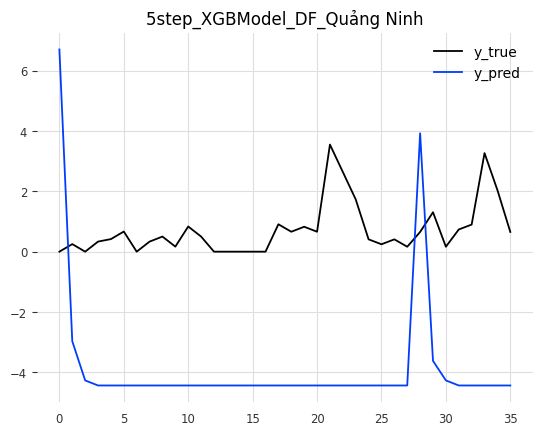

rmse,mae,mape,mse
5.193779164838804,5.094898926733137,4701074828412268.0,26.975342013113664
✨✨✨✨✨✨✨✨6✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨RandomForest✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨Bình Phước✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,n_estimators,max_depth,random_state
0,Bình Phước,RandomForest,19.908509,1,8,"-6,-7,-8",1,192,1,5
1,An Giang,RandomForest,7.921622,1,8,"-6,-7,-8",1,116,1,20
2,Quảng Ninh,RandomForest,10.143256,1,8,"-6,-7,-8",1,162,15,9


🐝Oát zúppppp
🐝Nà ní đa phắc
🐝Still fine
🐝Nee
mean_squared_error: 307.4226
rmse: 17.533469682112447
mape: 3.3979506004733526


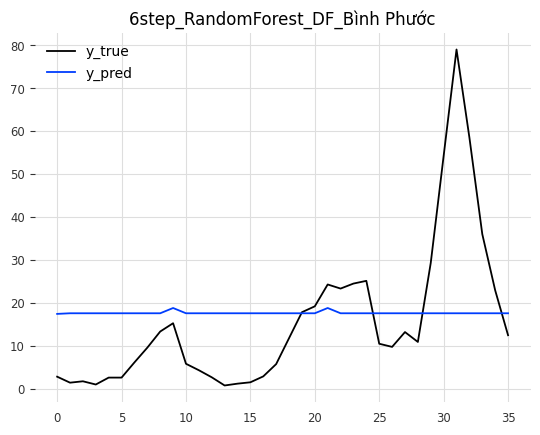

rmse,mae,mape,mse
17.533469682112447,13.18988681823401,3.3979506004733526,307.4225590935564
✨✨✨✨✨✨✨✨An Giang✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,n_estimators,max_depth,random_state
0,Bình Phước,RandomForest,19.908509,1,8,"-6,-7,-8",1,192,1,5
1,An Giang,RandomForest,7.921622,1,8,"-6,-7,-8",1,116,1,20
2,Quảng Ninh,RandomForest,10.143256,1,8,"-6,-7,-8",1,162,15,9


🐝Oát zúppppp
🐝Nà ní đa phắc
🐝Still fine
🐝Nee
mean_squared_error: 66.6059
rmse: 8.161242228128621
mape: 1.220867753113935


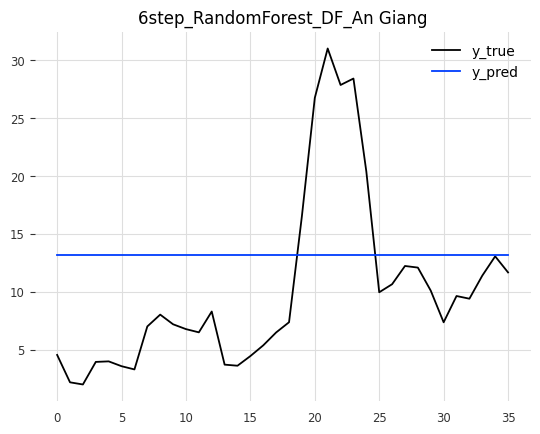

rmse,mae,mape,mse
8.161242228128621,6.997105592287685,1.220867753113935,66.60587470618984
✨✨✨✨✨✨✨✨Quảng Ninh✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,n_estimators,max_depth,random_state
0,Bình Phước,RandomForest,19.908509,1,8,"-6,-7,-8",1,192,1,5
1,An Giang,RandomForest,7.921622,1,8,"-6,-7,-8",1,116,1,20
2,Quảng Ninh,RandomForest,10.143256,1,8,"-6,-7,-8",1,162,15,9


🐝Oát zúppppp
🐝Nà ní đa phắc
🐝Still fine
🐝Nee
mean_squared_error: 89.6741
rmse: 9.469638506086762
mape: 7666837741053612.0


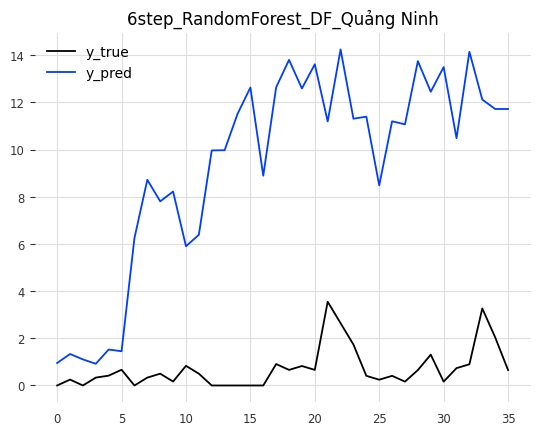

rmse,mae,mape,mse
9.469638506086762,8.586046790107723,7666837741053612.0,89.67405343596113
✨✨✨✨✨✨✨✨LinearRegressionModel✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨Bình Phước✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,random_state
0,Bình Phước,LinearRegressionModel,15.771818,1,8,"-6,-7,-8",1,23
1,An Giang,LinearRegressionModel,8.749062,1,8,"-6,-7,-8",1,14
2,Quảng Ninh,LinearRegressionModel,1.866650,1,8,"-6,-7,-8",1,20


🐝Oát zúppppp
🐝Nà ní đa phắc
🐝Still fine
🐝Nee
mean_squared_error: 371.1929
rmse: 19.26636746147776
mape: 3.904605718860187


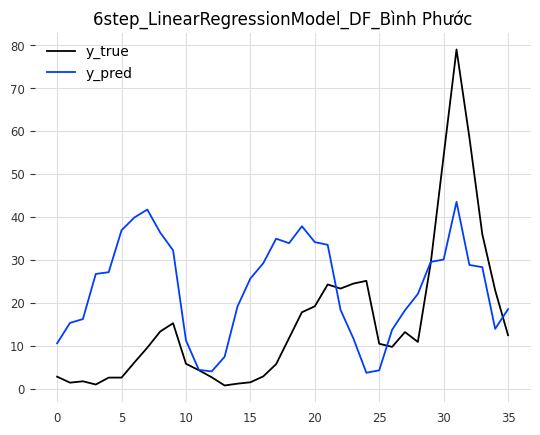

rmse,mae,mape,mse
19.26636746147776,16.16129713965195,3.904605718860187,371.1929151606889
✨✨✨✨✨✨✨✨An Giang✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,random_state
0,Bình Phước,LinearRegressionModel,15.771818,1,8,"-6,-7,-8",1,23
1,An Giang,LinearRegressionModel,8.749062,1,8,"-6,-7,-8",1,14
2,Quảng Ninh,LinearRegressionModel,1.866650,1,8,"-6,-7,-8",1,20


🐝Oát zúppppp
🐝Nà ní đa phắc
🐝Still fine
🐝Nee
mean_squared_error: 164.5409
rmse: 12.827349620781282
mape: 1.7705520705528868


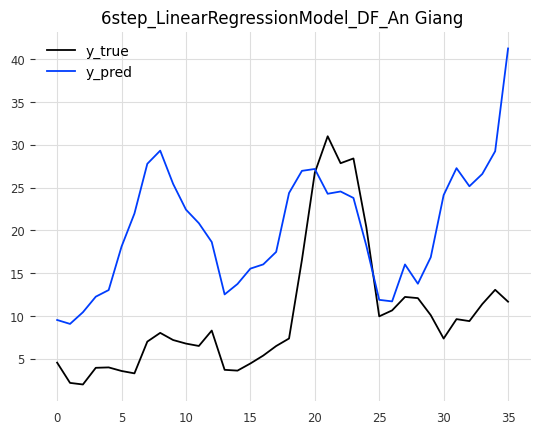

rmse,mae,mape,mse
12.827349620781282,10.950017987954766,1.7705520705528868,164.54089829375772
✨✨✨✨✨✨✨✨Quảng Ninh✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,random_state
0,Bình Phước,LinearRegressionModel,15.771818,1,8,"-6,-7,-8",1,23
1,An Giang,LinearRegressionModel,8.749062,1,8,"-6,-7,-8",1,14
2,Quảng Ninh,LinearRegressionModel,1.866650,1,8,"-6,-7,-8",1,20


🐝Oát zúppppp
🐝Nà ní đa phắc
🐝Still fine
🐝Nee
mean_squared_error: 4.2068
rmse: 2.0510579175118804
mape: 1886130399211342.8


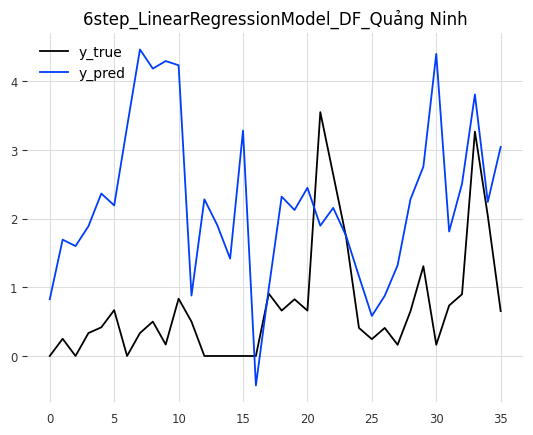

rmse,mae,mape,mse
2.0510579175118804,1.668968770020086,1886130399211342.8,4.206838580988171
✨✨✨✨✨✨✨✨CatBoostModel✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨Bình Phước✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,learning_rate,n_estimators,max_depth,random_state,likelihood,quantiles,bagging_temperature,border_count,l2_leaf_reg,random_strength
0,Bình Phước,CatBoost,19.061518,1,8,"-6,-7,-8",1,0.086546,159,10,618,quantile,"0.1,0.5,0.9",82.373108,181,1.623109,1.995695
1,An Giang,CatBoost,8.095235,1,8,"-6,-7,-8",1,0.011958,110,10,435,quantile,IsNone,96.523880,249,7.715653,5.508918
2,Quảng Ninh,CatBoost,4.685658,1,8,"-6,-7,-8",1,0.072048,196,4,352,quantile,IsNone,78.749326,126,8.951836,4.117587


🐝Oát zúppppp
🐝Nà ní đa phắc
🐝Still fine
🐝Nee
mean_squared_error: 732.7026
rmse: 27.06847963319395
mape: 4.906764229359144


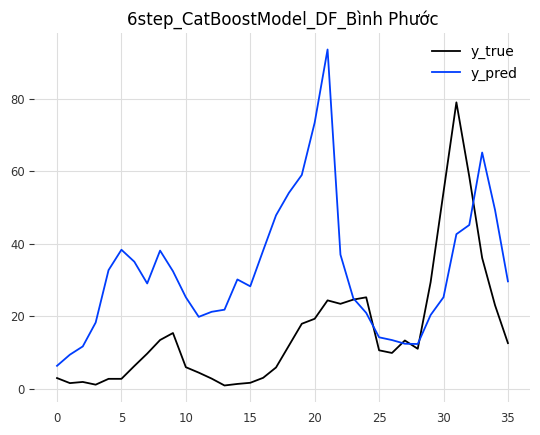

rmse,mae,mape,mse
27.06847963319395,22.095100546643717,4.906764229359144,732.7025896526357
✨✨✨✨✨✨✨✨An Giang✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,learning_rate,n_estimators,max_depth,random_state,likelihood,quantiles,bagging_temperature,border_count,l2_leaf_reg,random_strength
0,Bình Phước,CatBoost,19.061518,1,8,"-6,-7,-8",1,0.086546,159,10,618,quantile,"0.1,0.5,0.9",82.373108,181,1.623109,1.995695
1,An Giang,CatBoost,8.095235,1,8,"-6,-7,-8",1,0.011958,110,10,435,quantile,IsNone,96.523880,249,7.715653,5.508918
2,Quảng Ninh,CatBoost,4.685658,1,8,"-6,-7,-8",1,0.072048,196,4,352,quantile,IsNone,78.749326,126,8.951836,4.117587


🐝Oát zúppppp
🐝Nà ní đa phắc
🐝Still fine
🐝Nee
mean_squared_error: 57.0037
rmse: 7.5500823890738555
mape: 1.0291573787072383


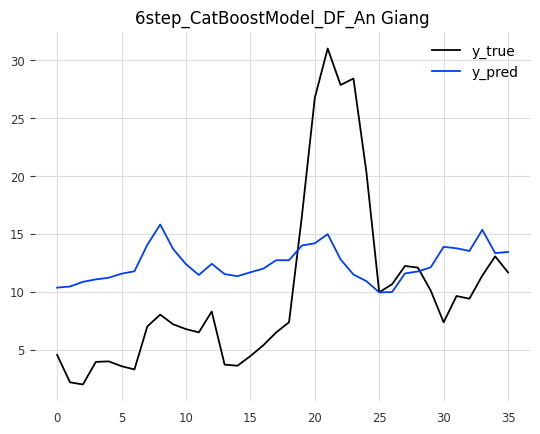

rmse,mae,mape,mse
7.5500823890738555,6.325034570978378,1.0291573787072383,57.003744081803184
✨✨✨✨✨✨✨✨Quảng Ninh✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,learning_rate,n_estimators,max_depth,random_state,likelihood,quantiles,bagging_temperature,border_count,l2_leaf_reg,random_strength
0,Bình Phước,CatBoost,19.061518,1,8,"-6,-7,-8",1,0.086546,159,10,618,quantile,"0.1,0.5,0.9",82.373108,181,1.623109,1.995695
1,An Giang,CatBoost,8.095235,1,8,"-6,-7,-8",1,0.011958,110,10,435,quantile,IsNone,96.523880,249,7.715653,5.508918
2,Quảng Ninh,CatBoost,4.685658,1,8,"-6,-7,-8",1,0.072048,196,4,352,quantile,IsNone,78.749326,126,8.951836,4.117587


🐝Oát zúppppp
🐝Nà ní đa phắc
🐝Still fine
🐝Nee
mean_squared_error: 54.9652
rmse: 7.413852157502177
mape: 6705146049294297.0


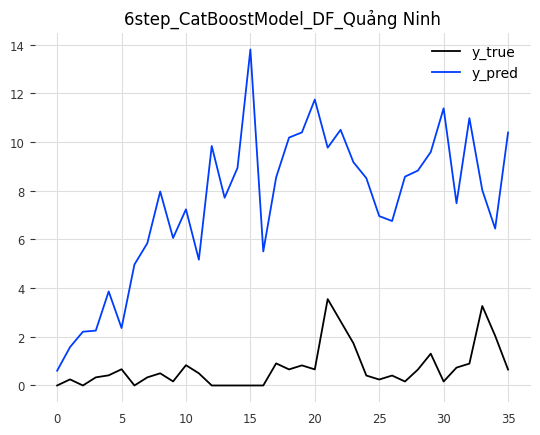

rmse,mae,mape,mse
7.413852157502177,6.786674465766812,6705146049294297.0,54.96520381329968
✨✨✨✨✨✨✨✨XGBModel✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨Bình Phước✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,random_state,likelihood
0,Bình Phước,XGBModel,47.728390,1,8,"-6,-7,-8",1,12,quantile
1,An Giang,XGBModel,36.817075,1,8,"-6,-7,-8",1,25,quantile
2,Quảng Ninh,XGBModel,3.908890,1,8,"-6,-7,-8",1,9,quantile


🐝Oát zúppppp
🐝Nà ní đa phắc
🐝Still fine
🐝Nee
mean_squared_error: 48990.5034
rmse: 221.33798463990505
mape: 32.429596429450015


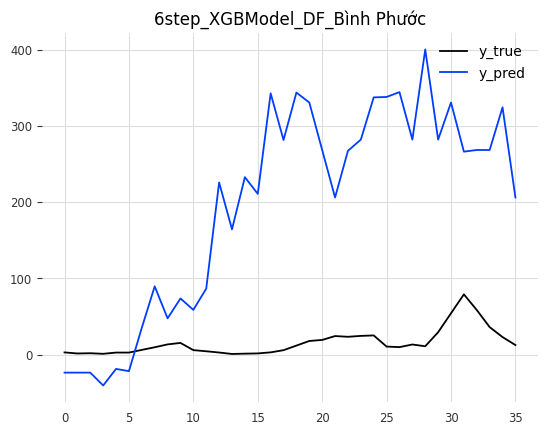

rmse,mae,mape,mse
221.33798463990505,189.13843134596388,32.429596429450015,48990.503444454844
✨✨✨✨✨✨✨✨An Giang✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,random_state,likelihood
0,Bình Phước,XGBModel,47.728390,1,8,"-6,-7,-8",1,12,quantile
1,An Giang,XGBModel,36.817075,1,8,"-6,-7,-8",1,25,quantile
2,Quảng Ninh,XGBModel,3.908890,1,8,"-6,-7,-8",1,9,quantile


🐝Oát zúppppp
🐝Nà ní đa phắc
🐝Still fine
🐝Nee
mean_squared_error: 2199.5466
rmse: 46.899323628193144
mape: 6.143344982536135


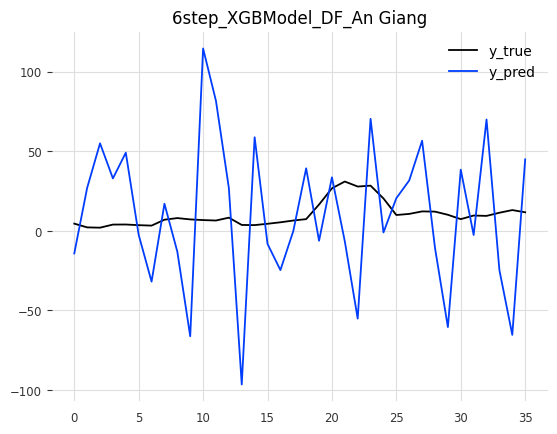

rmse,mae,mape,mse
46.899323628193144,38.60241573587473,6.143344982536135,2199.546556781996
✨✨✨✨✨✨✨✨Quảng Ninh✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,random_state,likelihood
0,Bình Phước,XGBModel,47.728390,1,8,"-6,-7,-8",1,12,quantile
1,An Giang,XGBModel,36.817075,1,8,"-6,-7,-8",1,25,quantile
2,Quảng Ninh,XGBModel,3.908890,1,8,"-6,-7,-8",1,9,quantile


🐝Oát zúppppp
🐝Nà ní đa phắc
🐝Still fine
🐝Nee
mean_squared_error: 28.9569
rmse: 5.381159279308297
mape: 4706270175743148.0


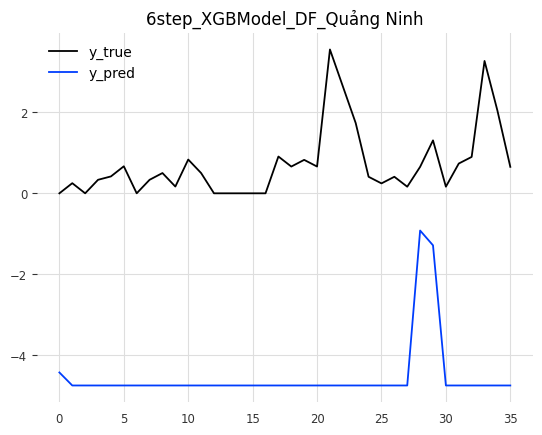

rmse,mae,mape,mse
5.381159279308297,5.251539954691347,4706270175743148.0,28.956875189285785


In [244]:
model_name_list = [
     "RandomForest",
     "LinearRegressionModel",
    #  "LightGBMModel",
     "CatBoostModel",
     "XGBModel",
    # "PoissonRegressor",
    # "SVMRBF"
]

for nstep in range(1,args.n_predicted_period_months+1):
# for nstep in range(1,2):
    print(f"✨✨✨✨✨✨✨✨{nstep}✨✨✨✨✨✨✨✨✨✨")
    for model_name in model_name_list:   
        print(f"✨✨✨✨✨✨✨✨{model_name}✨✨✨✨✨✨✨✨✨✨")
        for city in cities:
            print(f"✨✨✨✨✨✨✨✨{city}✨✨✨✨✨✨✨✨✨✨")
            df_train = pd.read_csv(output_process+city+'_train_preprocessed.csv', parse_dates=True, index_col= None, encoding = 'unicode_escape')
            df_valid = pd.read_csv(output_process+city+'_test_preprocessed.csv', parse_dates=True, index_col= None, encoding = 'unicode_escape')
            scaler = joblib.load(output_process+city+'_train_scalerMinMaxNorm.save') #ok
            is_sklearn_model = 0
            selected_features = getDataWithSelectedFeature(city, nstep)

            lags_by_nstep = args.look_back + nstep - 1
            lags_past_covariates_by_nstep = [-lags_by_nstep+2,-lags_by_nstep+1,-lags_by_nstep] #Mảng này chứa ba giá trị tương ứng cho args.lookback 3
            is_dl_algo = 0

            pl_trainer_kwargs = {
                        "accelerator": "cpu",
                        # "devices": -1,
                        # "auto_select_gpus": True,
                    }

            df_hyper_params = getHyperParams(model_name, city, nstep)

            if model_name == "RandomForest":
                    lags = df_hyper_params['lags'].values[0]
                    lags_past_covariates = df_hyper_params['lags_past_covariates'].values[0].split(',')
                    lags_past_covariates = [int(i) for i in lags_past_covariates]
                    output_chunk_length = df_hyper_params['output_chunk_length'].values[0]
                    n_estimators = df_hyper_params['n_estimators'].values[0]
                    max_depth = df_hyper_params['max_depth'].values[0]
                    random_state = df_hyper_params['random_state'].values[0]
                    # Create the RandomForest model
                    model = RandomForest(
                                    lags = int(lags),
                                    lags_past_covariates = lags_past_covariates_by_nstep,
                                    output_chunk_length = int(output_chunk_length),
                                    n_estimators = int(n_estimators),
                                    max_depth = int(max_depth),
                                    random_state=int(random_state))
            elif model_name == 'XGBModel':
                    lags = df_hyper_params['lags'].values[0]
                    lags_past_covariates = df_hyper_params['lags_past_covariates'].values[0].split(',')
                    lags_past_covariates = [int(i) for i in lags_past_covariates]
                    output_chunk_length = df_hyper_params['output_chunk_length'].values[0]
                    random_state = df_hyper_params['random_state'].values[0]
                    likelihood = df_hyper_params['likelihood'].values[0]
                    # Create the  model
                    model = XGBModel(
                                    lags = int(lags),
                                    lags_past_covariates = lags_past_covariates,
                                    output_chunk_length = int(output_chunk_length),
                                    random_state=int(random_state),
                                    likelihood = likelihood
                                    )
            elif model_name == 'LinearRegressionModel':
                    lags = df_hyper_params['lags'].values[0]
                    lags_past_covariates = df_hyper_params['lags_past_covariates'].values[0].split(',')
                    lags_past_covariates = [int(i) for i in lags_past_covariates]
                    output_chunk_length = df_hyper_params['output_chunk_length'].values[0]
                    random_state = df_hyper_params['random_state'].values[0]
                    # Create the  model
                    model = LinearRegressionModel(
                                    lags = int(lags),
                                    lags_past_covariates = lags_past_covariates,
                                    output_chunk_length = int(output_chunk_length),
                                    random_state=int(random_state))
            elif model_name == "CatBoostModel":
                    lags = df_hyper_params['lags'].values[0]
                    lags_past_covariates = df_hyper_params['lags_past_covariates'].values[0].split(',')
                    lags_past_covariates = [int(i) for i in lags_past_covariates]
                    learning_rate = df_hyper_params['learning_rate'].values[0]
                    n_estimators = df_hyper_params['n_estimators'].values[0]
                    max_depth = df_hyper_params['max_depth'].values[0]
                    output_chunk_length = df_hyper_params['output_chunk_length'].values[0]
                    likelihood = df_hyper_params['likelihood'].values[0]
                    bagging_temperature = df_hyper_params['bagging_temperature'].values[0]
                    border_count = df_hyper_params['border_count'].values[0]
                    l2_leaf_reg = df_hyper_params['l2_leaf_reg'].values[0]
                    random_strength = df_hyper_params['random_strength'].values[0]
                    opt_quantitles = df_hyper_params['quantiles'].values[0]
                    if opt_quantitles == "IsNone":
                        quantitles = None
                    else:
                        quantitles = df_hyper_params['quantiles'].values[0].split(',')
                    model = CatBoostModel(
                                            lags=int(lags),
                                            lags_past_covariates=lags_past_covariates, 
                                            learning_rate=float(learning_rate),
                                            n_estimators= int(n_estimators),
                                            max_depth=int(max_depth), 
                                            output_chunk_length = int(output_chunk_length),
                                            likelihood = likelihood,
                                            # quantiles = float(quantiles), #None or float
                                            bagging_temperature = float(bagging_temperature),
                                            # border_count = int(border_count),
                                            l2_leaf_reg = float(l2_leaf_reg),
                                            random_strength = float(random_strength),
                                            random_state=int(random_state))
            elif model_name == "LightGBMModel":
                    lags = df_hyper_params['lags'].values[0]
                    lags_past_covariates = df_hyper_params['lags_past_covariates'].values[0].split(',')
                    lags_past_covariates = [int(i) for i in lags_past_covariates]
                    output_chunk_length = df_hyper_params['output_chunk_length'].values[0]
                    random_state = df_hyper_params['random_state'].values[0]
                    multi_models = df_hyper_params['multi_models'].values[0]
                    likelihood = df_hyper_params['likelihood'].values[0]
                    num_leaves = df_hyper_params['num_leaves'].values[0]
                    learning_rate = df_hyper_params['learning_rate'].values[0]
                    feature_fraction = df_hyper_params['feature_fraction'].values[0]
                    bagging_fraction = df_hyper_params['bagging_fraction'].values[0]
                    min_child_samples = df_hyper_params['min_child_samples'].values[0]
                    lambda_l1 = df_hyper_params['lambda_l1'].values[0]
                    verbose = df_hyper_params['verbose'].values[0]
                    model = LightGBMModel(
                        lags =int(lags),
                        lags_past_covariates = lags_past_covariates,
                        output_chunk_length = int(output_chunk_length),
                        random_state = int(random_state),
                        multi_models = bool(multi_models),
                        likelihood = likelihood,
                        num_leaves = int(num_leaves),
                        learning_rate = float(learning_rate),
                        feature_fraction = float(feature_fraction),
                        bagging_fraction = float(bagging_fraction),
                        min_child_samples = int(min_child_samples),
                        lambda_l1 = float(lambda_l1),
                        verbose = int(verbose)
                    )
            elif model_name == 'SVMRBF':
                    max_iter = df_hyper_params['max_iter'].values[0]
                    epsilon = df_hyper_params['epsilon'].values[0],
                    model = SVR(
                        max_iter = max_iter,
                        kernel = 'rbf',
                        epsilon = epsilon[0]
                    )
                    is_sklearn_model = 1
            elif model_name == "PoissonRegressor":
                    max_iter = df_hyper_params['max_iter'].values[0]
                    alpha = df_hyper_params['alpha'].values[0],
                    model = PoissonRegressor(
                        max_iter = max_iter,
                        fit_intercept = False,
                        alpha = alpha[0]
                    )
                    is_sklearn_model = 1        
            df, model = output_prediction_for_location(df_train, df_valid, model, location=city, feature_list=selected_features,
                                                            labels=args.labels, scaler=scaler, is_dl_algo = is_dl_algo,is_sklearn_model = is_sklearn_model, nstep = nstep)
            df.to_excel(f"./predict_results/0_train_{nstep}nstep_denguefever_prediction_results_by_{model_name}_in_{city}.xlsx")
            pickle.dump(model, open(f"./trained_models/{nstep}nstep_denguefever_{model_name}_in_{city}.sav", 'wb'))